# Face Clustering Visualization and Explainability Analysis

This notebook provides interactive visualizations of clustering results and explainability analysis using SHAP and LIME.

In [20]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import cv2
import pickle
import shap
from lime import lime_tabular
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

## Load Data and Models

Load the clustering results, PCA model, and scaler for face reconstruction.

In [21]:
df = pd.read_csv('final_clustering.csv')

model_path = 'pca_scaler_model.pickle'

try:
    with open(model_path, 'rb') as f:
        loaded_data = pickle.load(f)
        
    scaler = loaded_data['scaler']
    pca = loaded_data['pca']
    
    print("Successfully loaded 'pca_scaler_model.pickle'")
    print(f"   - Components: {pca.n_components_}")
    
except FileNotFoundError:
    print(f"Error: Could not find '{model_path}'. Please check the file path.")
    raise

Successfully loaded 'pca_scaler_model.pickle'
   - Components: 248


## Define Principal Component Columns

In [22]:
pc_columns = [f'PC_{i}' for i in range(1, pca.n_components_ + 1)]

## Interactive 3D Plot Function

This function creates an interactive 3D scatter plot with face reconstruction on click. Each point represents a face sample colored by its cluster assignment.

In [23]:
def create_interactive_plot(dataframe, cluster_column, method_name, pc_cols_list, pca_model, scaler_model, color_theme='Viridis'):
    
    trace = go.Scatter3d(
        x=dataframe['PC_1'],
        y=dataframe['PC_2'],
        z=dataframe['PC_3'],
        mode='markers',
        marker=dict(
            size=4,
            color=dataframe[cluster_column],
            colorscale=color_theme,
            opacity=0.8,
            colorbar=dict(title='Cluster ID')
        ),
        text=dataframe['person_name'],
        hoverinfo='text'
    )

    layout = go.Layout(
        title=f'3D Visualization: {method_name}',
        scene=dict(
            xaxis_title='PC 1',
            yaxis_title='PC 2',
            zaxis_title='PC 3'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        height=600
    )

    fig = go.FigureWidget(data=[trace], layout=layout)

    image_widget = widgets.Image(
        format='png',
        width=300,
        height=300,
        value=b''
    )
    
    output_label = widgets.Label(value="Click a point to reconstruct the face.")

    def update_image(trace, points, selector):
        if not points.point_inds:
            return
            
        idx = points.point_inds[0]
        
        try:
            pca_features = dataframe.iloc[idx][pc_cols_list].values.reshape(1, -1)
            reconstructed_scaled = pca_model.inverse_transform(pca_features)
            reconstructed_pixels = scaler_model.inverse_transform(reconstructed_scaled)
            img_array = np.clip(reconstructed_pixels.reshape(250, 250), 0, 255).astype(np.uint8)
            
            _, encoded_img = cv2.imencode('.png', img_array)
            image_widget.value = encoded_img.tobytes()
            
            name = dataframe.iloc[idx]['person_name']
            cluster = dataframe.iloc[idx][cluster_column]
            output_label.value = f"Name: {name} | Cluster: {cluster}"
            
        except Exception as e:
            output_label.value = f"Error: {str(e)}"

    fig.data[0].on_click(update_image)

    return widgets.HBox([fig, widgets.VBox([output_label, image_widget])])

## Interactive Clustering Visualizations

Below we create five different 3D visualizations, each representing a different clustering method applied to the face dataset. Each tab uses a unique color theme to distinguish the clusters:

| Tab | Clustering Method | Color Theme |
|-----|-------------------|-------------|
| K-Means | Centroid-based partitioning | Viridis (Green/Purple) |
| SOM | Self-Organizing Maps | Plasma (Blue/Red/Yellow) |
| Hierarchical | Agglomerative clustering | Turbo (Rainbow) |
| DBSCAN | Density-based clustering | Inferno (Black/Red/Yellow) |
| Face Groups | Face similarity groupings | Cividis (Blue/Yellow/Grey) |

**Interactive Features:**
- Rotate, zoom, and pan the 3D scatter plot
- Hover over points to see person names
- Click on any point to reconstruct and display the face image

In [24]:
tab1 = create_interactive_plot(df, 'kmeans_cluster', 'K-Means Clustering', pc_columns, pca, scaler, color_theme='Viridis')
tab2 = create_interactive_plot(df, 'som_cluster', 'SOM (Bonus)', pc_columns, pca, scaler, color_theme='Plasma')
tab3 = create_interactive_plot(df, 'hierarchical_cluster', 'Hierarchical Clustering', pc_columns, pca, scaler, color_theme='Turbo')
tab4 = create_interactive_plot(df, 'dbscan_cluster', 'DBSCAN (Density Based)', pc_columns, pca, scaler, color_theme='Inferno')
tab5 = create_interactive_plot(df, 'face_group', 'Face Similarity Groups', pc_columns, pca, scaler, color_theme='Cividis')

tabs = widgets.Tab(children=[tab1, tab2, tab3, tab4, tab5])
tabs.set_title(0, 'K-Means')
tabs.set_title(1, 'SOM')
tabs.set_title(2, 'Hierarchical')
tabs.set_title(3, 'DBSCAN')
tabs.set_title(4, 'Face Groups')

display(tabs)

    'data': [{'hoverinfo': 'text',
              'marker': {'color…

---
# Task 1: Feature-Level Explanation

Using interpretable surrogate models (Decision Tree, Logistic Regression, Random Forest) to understand which principal components drive the clustering decisions. We apply SHAP and LIME to determine which embedding dimensions most influenced cluster assignments.

In [25]:
labels_df = pd.read_csv('all_clustering_labels.csv')
pca_df = pd.read_csv('pca_features_variance.csv')

## Prepare Features and Labels

Extract PCA features and clustering labels for training surrogate models.

In [26]:
labels = labels_df.drop(columns=['person_name'])
pca_features = pca_df.drop(columns=['person_name'])

X = pca_features.values
feature_names = pca_features.columns.tolist()

## Train Interpretable Surrogate Models

Train three types of surrogate models to approximate each clustering method:
1. **Decision Tree**: Highly interpretable, provides clear decision rules
2. **Logistic Regression**: Linear model with interpretable coefficients
3. **Random Forest**: Ensemble method for comparison and feature importance

In [27]:
surrogate_models = {}
clustering_methods = ['kmeans_cluster', 'som_cluster', 'hierarchical_cluster', 'dbscan_cluster']

for method in clustering_methods:
    y = labels[method].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    dt = DecisionTreeClassifier(max_depth=10, random_state=42)
    dt.fit(X_train, y_train)
    dt_accuracy = dt.score(X_test, y_test)
    
    lr = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
    lr.fit(X_train, y_train)
    lr_accuracy = lr.score(X_test, y_test)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_accuracy = rf.score(X_test, y_test)
    
    surrogate_models[method] = {
        'decision_tree': {'model': dt, 'accuracy': dt_accuracy},
        'logistic_regression': {'model': lr, 'accuracy': lr_accuracy},
        'random_forest': {'model': rf, 'accuracy': rf_accuracy},
        'X_train': X_train, 'X_test': X_test, 
        'y_train': y_train, 'y_test': y_test
    }
    
    print(f"\n{method}:")
    print(f"   Decision Tree accuracy:      {dt_accuracy:.4f}")
    print(f"   Logistic Regression accuracy: {lr_accuracy:.4f}")
    print(f"   Random Forest accuracy:       {rf_accuracy:.4f}")


kmeans_cluster:
   Decision Tree accuracy:      0.8127
   Logistic Regression accuracy: 0.8740
   Random Forest accuracy:       0.8035

som_cluster:
   Decision Tree accuracy:      0.2532
   Logistic Regression accuracy: 0.4012
   Random Forest accuracy:       0.2532

hierarchical_cluster:
   Decision Tree accuracy:      0.5838
   Logistic Regression accuracy: 0.6520
   Random Forest accuracy:       0.6000

dbscan_cluster:
   Decision Tree accuracy:      0.7283
   Logistic Regression accuracy: 0.7723
   Random Forest accuracy:       0.8104


## Decision Tree Visualization

Decision Trees provide explicit rules for cluster assignment. Below we visualize the tree structure for one clustering method.

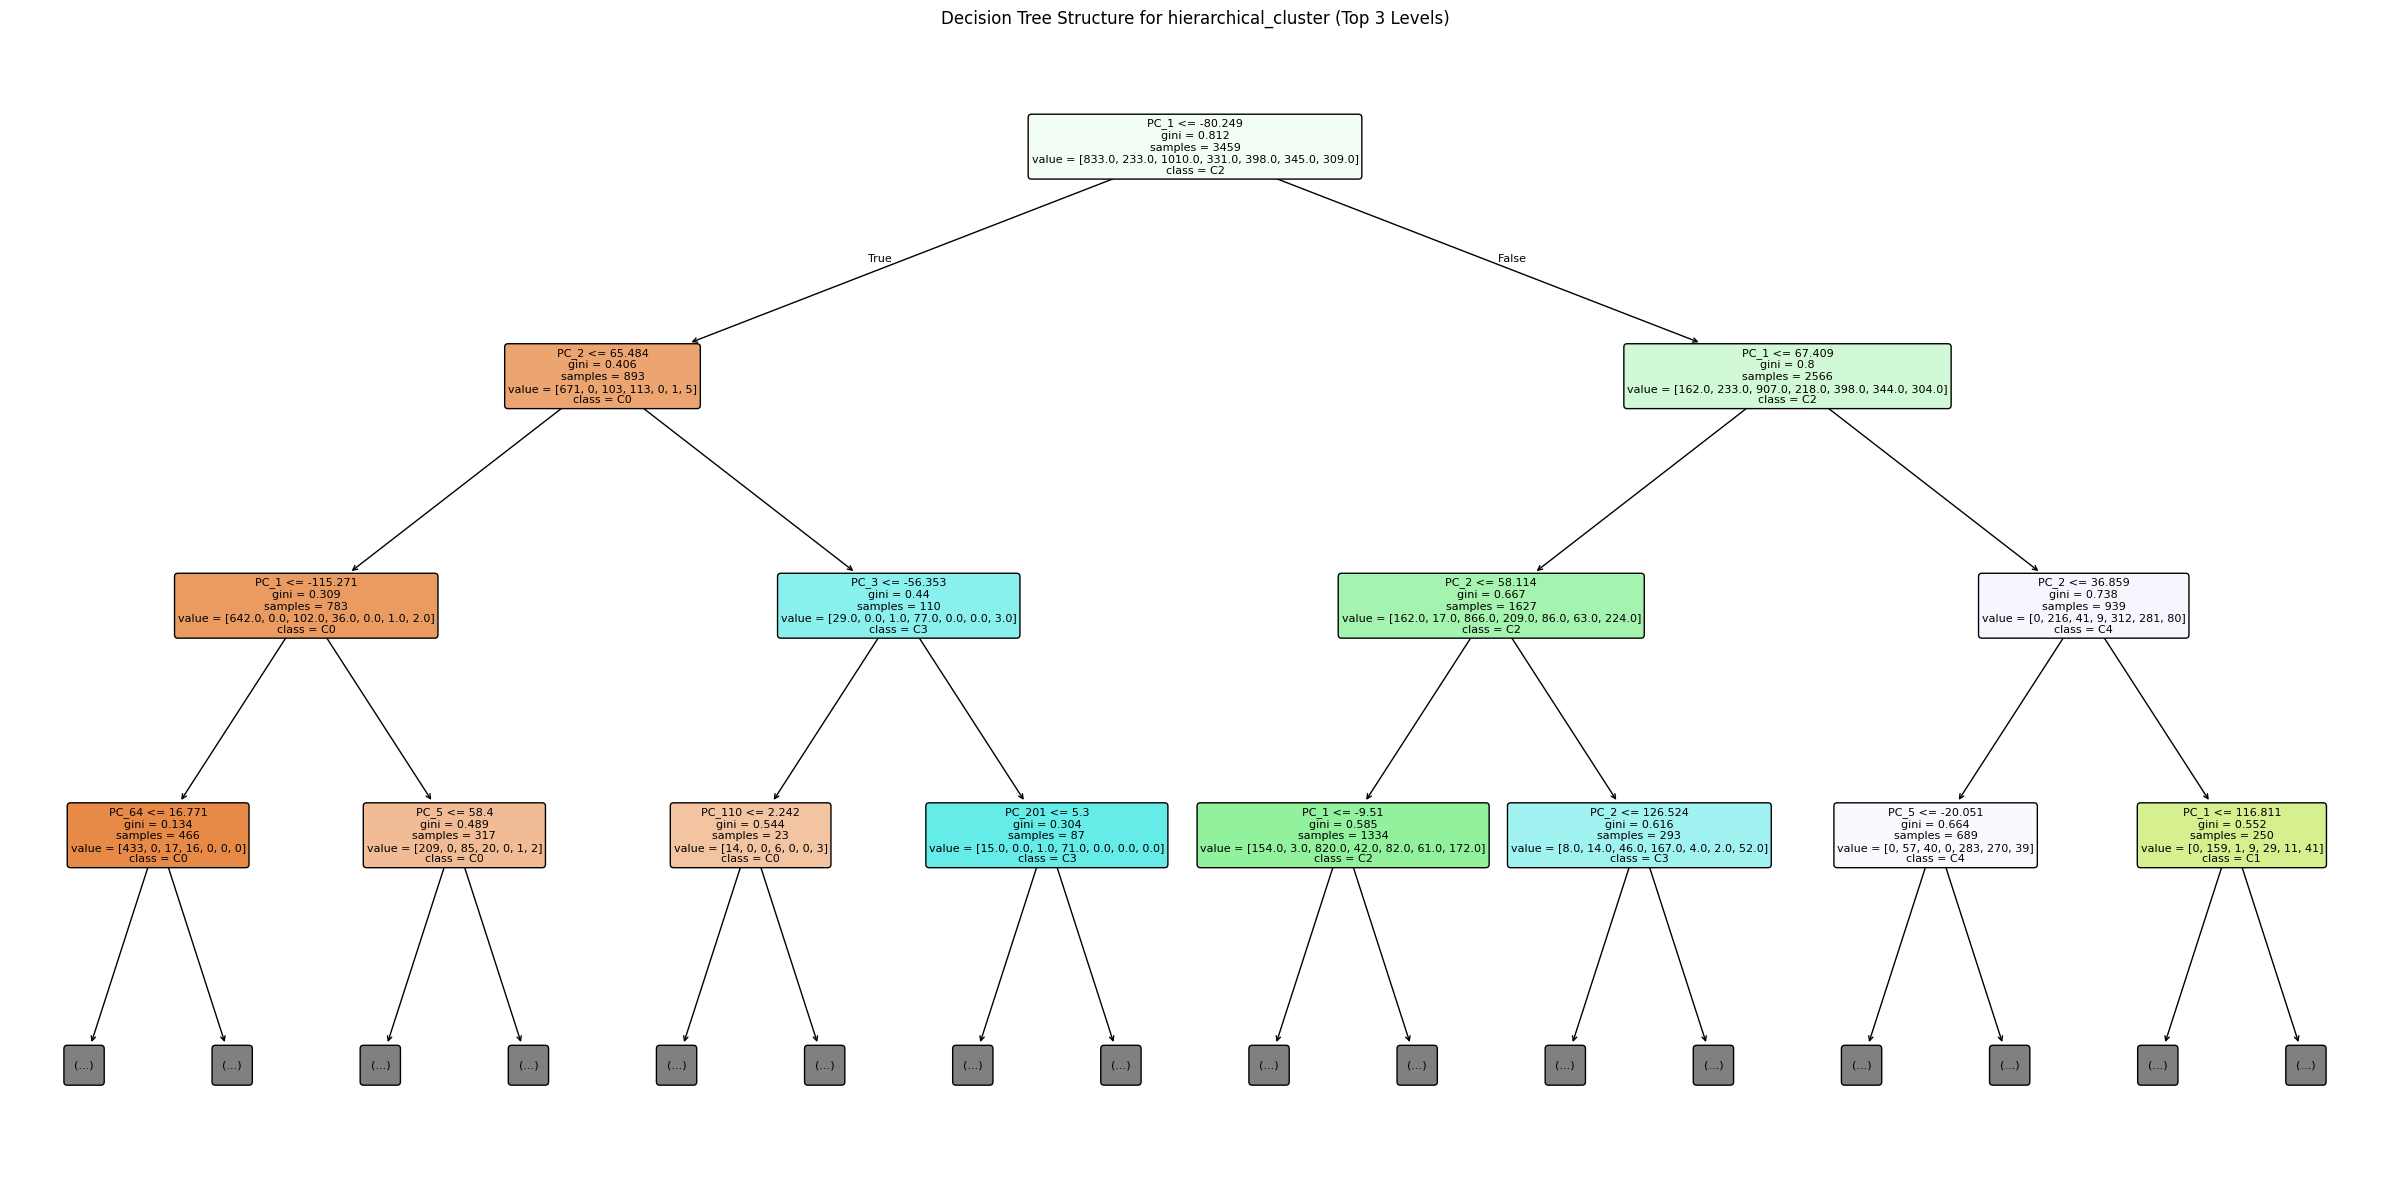


Top Decision Rules (Feature Importance from Decision Tree):
Feature  Importance
   PC_1    0.349975
   PC_2    0.157043
   PC_5    0.079594
   PC_3    0.033078
   PC_4    0.017390
  PC_12    0.010648
   PC_6    0.009910
   PC_8    0.007522
 PC_146    0.007393
  PC_48    0.006558
 PC_166    0.006493
 PC_110    0.006321
 PC_121    0.006156
  PC_26    0.005981
  PC_34    0.005463


In [28]:
clustering_methods = ['kmeans_cluster', 'som_cluster', 'hierarchical_cluster', 'dbscan_cluster']
method = random.choice(clustering_methods)
dt_model = surrogate_models[method]['decision_tree']['model']

plt.figure(figsize=(24, 12))
plot_tree(dt_model, 
          feature_names=feature_names, 
          class_names=[f'C{i}' for i in range(len(np.unique(surrogate_models[method]['y_train'])))],
          filled=True, 
          rounded=True,
          max_depth=3,
          fontsize=8)
plt.title(f'Decision Tree Structure for {method} (Top 3 Levels)')
plt.tight_layout()
plt.show()

print("\nTop Decision Rules (Feature Importance from Decision Tree):")
dt_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)
print(dt_importance.to_string(index=False))

## Logistic Regression Coefficients Analysis

For Logistic Regression, the coefficients indicate the influence of each principal component on cluster membership. Positive coefficients push toward a cluster, negative coefficients push away.

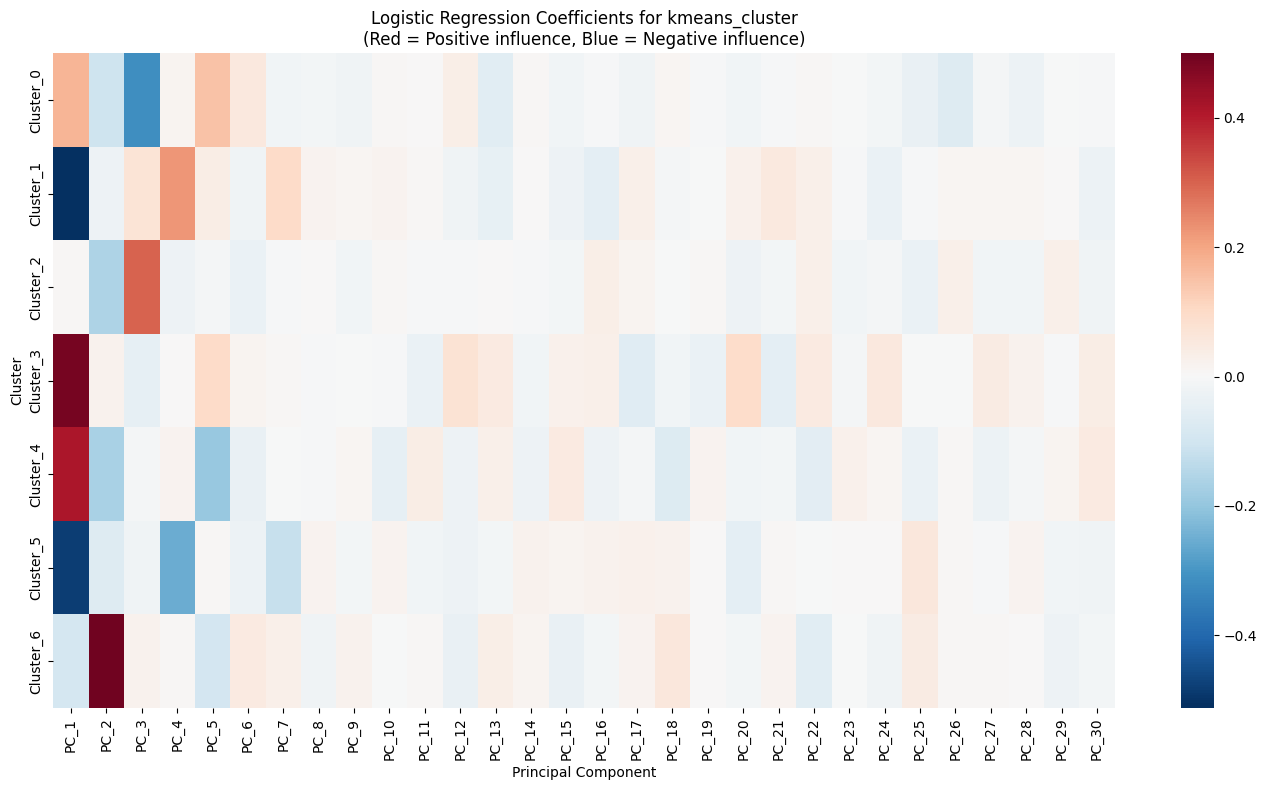


Top 15 Most Influential Features (Logistic Regression):
Feature  Avg Coefficient Magnitude
   PC_1                   0.309720
   PC_2                   0.149889
   PC_3                   0.112586
   PC_5                   0.084992
   PC_4                   0.078902
 PC_125                   0.060227
 PC_128                   0.060126
 PC_143                   0.059636
 PC_107                   0.059636
  PC_72                   0.059270
 PC_110                   0.057293
 PC_138                   0.056612
 PC_175                   0.055233
 PC_193                   0.054290
 PC_124                   0.053956


In [29]:
clustering_methods = ['kmeans_cluster', 'som_cluster', 'hierarchical_cluster', 'dbscan_cluster']
method = random.choice(clustering_methods)
lr_model = surrogate_models[method]['logistic_regression']['model']
n_clusters = len(lr_model.classes_)

avg_coef_magnitude = np.mean(np.abs(lr_model.coef_), axis=0)

plt.figure(figsize=(14, 8))
coef_df = pd.DataFrame(
    lr_model.coef_[:, :30],
    index=[f'Cluster_{c}' for c in lr_model.classes_],
    columns=feature_names[:30]
)
sns.heatmap(coef_df, cmap='RdBu_r', center=0, annot=False)
plt.title(f'Logistic Regression Coefficients for {method}\n(Red = Positive influence, Blue = Negative influence)')
plt.xlabel('Principal Component')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

top_lr_features = pd.DataFrame({
    'Feature': feature_names,
    'Avg Coefficient Magnitude': avg_coef_magnitude
}).sort_values('Avg Coefficient Magnitude', ascending=False).head(15)

print("\nTop 15 Most Influential Features (Logistic Regression):")
print(top_lr_features.to_string(index=False))

## Comparative Feature Importance Across Models

Compare which principal components are consistently important across all three surrogate model types.

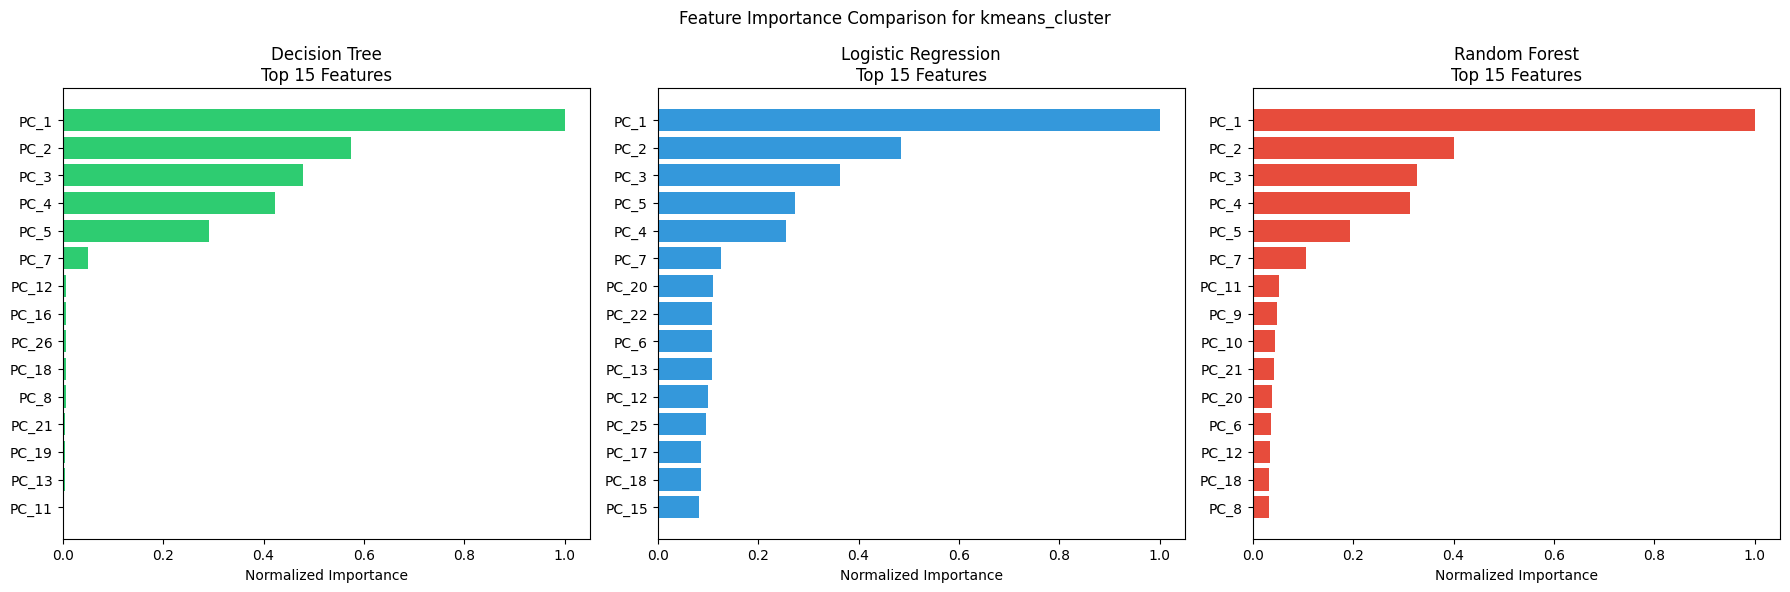

In [30]:
clustering_methods = ['kmeans_cluster', 'som_cluster', 'hierarchical_cluster', 'dbscan_cluster']
method = random.choice(clustering_methods)

dt_model = surrogate_models[method]['decision_tree']['model']
lr_model = surrogate_models[method]['logistic_regression']['model']
rf_model = surrogate_models[method]['random_forest']['model']

dt_imp = dt_model.feature_importances_ / dt_model.feature_importances_.max()
lr_imp = np.mean(np.abs(lr_model.coef_), axis=0)
lr_imp = lr_imp / lr_imp.max()
rf_imp = rf_model.feature_importances_ / rf_model.feature_importances_.max()

comparison_df = pd.DataFrame({
    'Feature': feature_names[:30],
    'Decision Tree': dt_imp[:30],
    'Logistic Regression': lr_imp[:30],
    'Random Forest': rf_imp[:30]
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, model_name in enumerate(['Decision Tree', 'Logistic Regression', 'Random Forest']):
    sorted_df = comparison_df.nlargest(15, model_name)
    axes[idx].barh(sorted_df['Feature'], sorted_df[model_name], color=['#2ecc71', '#3498db', '#e74c3c'][idx])
    axes[idx].set_xlabel('Normalized Importance')
    axes[idx].set_title(f'{model_name}\nTop 15 Features')
    axes[idx].invert_yaxis()

plt.suptitle(f'Feature Importance Comparison for {method}')
plt.tight_layout()
plt.show()

## SHAP Analysis - Global Feature Importance

SHAP (SHapley Additive exPlanations) values show how each principal component contributes to cluster predictions across the dataset. We analyze which embedding dimensions most influenced cluster assignments.

In [31]:
shap_results = {}

for method in clustering_methods:
    model = surrogate_models[method]['random_forest']['model']
    X_sample = surrogate_models[method]['X_test'][:100]
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample, check_additivity=False)
    
    shap_results[method] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'X_sample': X_sample
    }
    print(f"SHAP values computed for {method}")

SHAP values computed for kmeans_cluster
SHAP values computed for som_cluster
SHAP values computed for hierarchical_cluster
SHAP values computed for dbscan_cluster


### SHAP Summary Bar Plot

Shows the mean absolute SHAP value for each feature, indicating overall importance for cluster prediction.

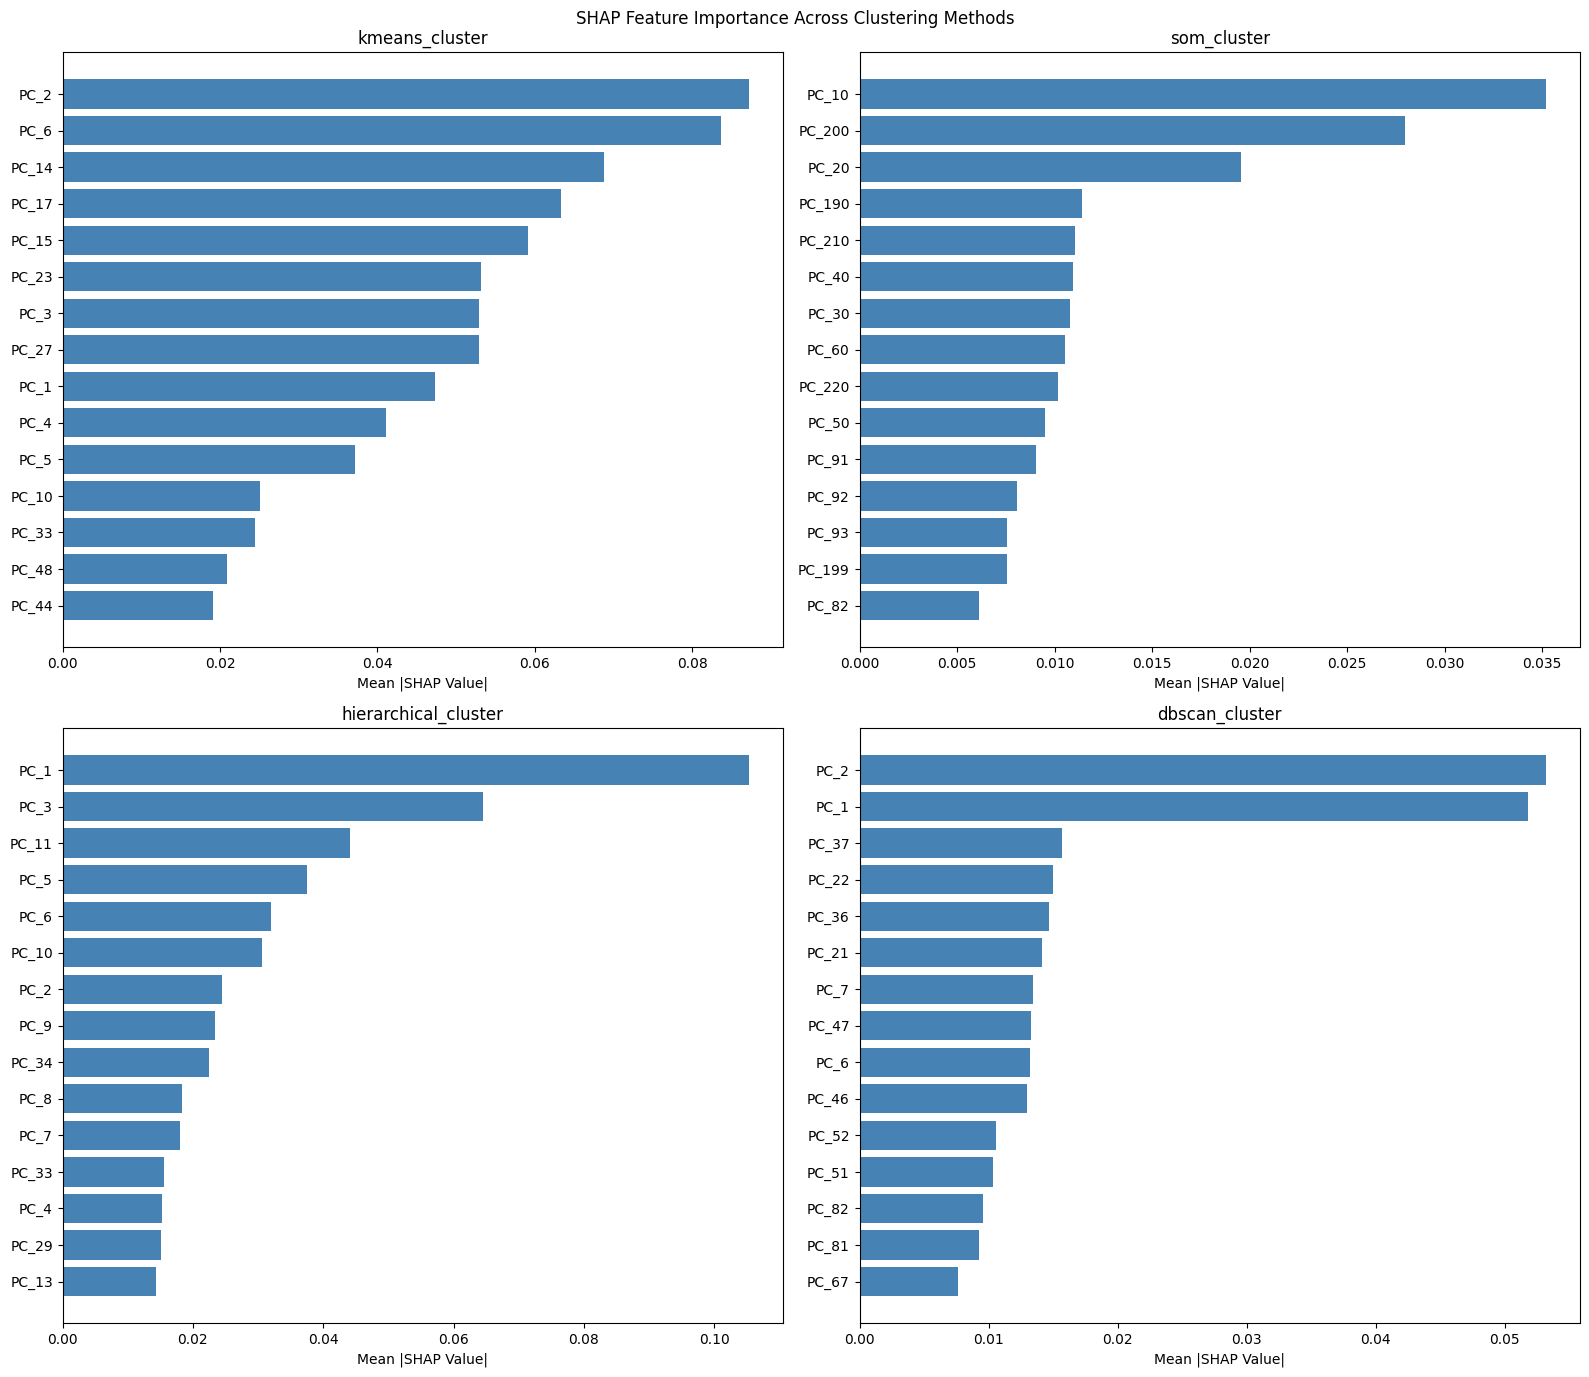

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, method in enumerate(clustering_methods):
    plt.sca(axes[idx])
    shap_vals = shap_results[method]['shap_values']
    X_sample = shap_results[method]['X_sample']
    
    if isinstance(shap_vals, list):
        stacked = np.array([np.abs(sv).mean(axis=0) for sv in shap_vals])
        mean_shap = stacked.mean(axis=0)
    else:
        mean_shap = np.abs(shap_vals).mean(axis=0)
    
    mean_shap = np.array(mean_shap).flatten()
    
    n_features_available = min(len(mean_shap), len(feature_names))
    n_top = min(15, n_features_available)
    
    top_indices = np.argsort(mean_shap[:n_features_available])[-n_top:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_values = [mean_shap[i] for i in top_indices]
    
    axes[idx].barh(range(len(top_features)), top_values[::-1], color='steelblue')
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features[::-1])
    axes[idx].set_xlabel('Mean |SHAP Value|')
    axes[idx].set_title(f'{method}')

plt.suptitle('SHAP Feature Importance Across Clustering Methods')
plt.tight_layout()
plt.show()

### SHAP Beeswarm Plot

Shows the distribution of SHAP values for each feature. Color indicates feature value (red=high, blue=low).

<Figure size 2000x1500 with 0 Axes>

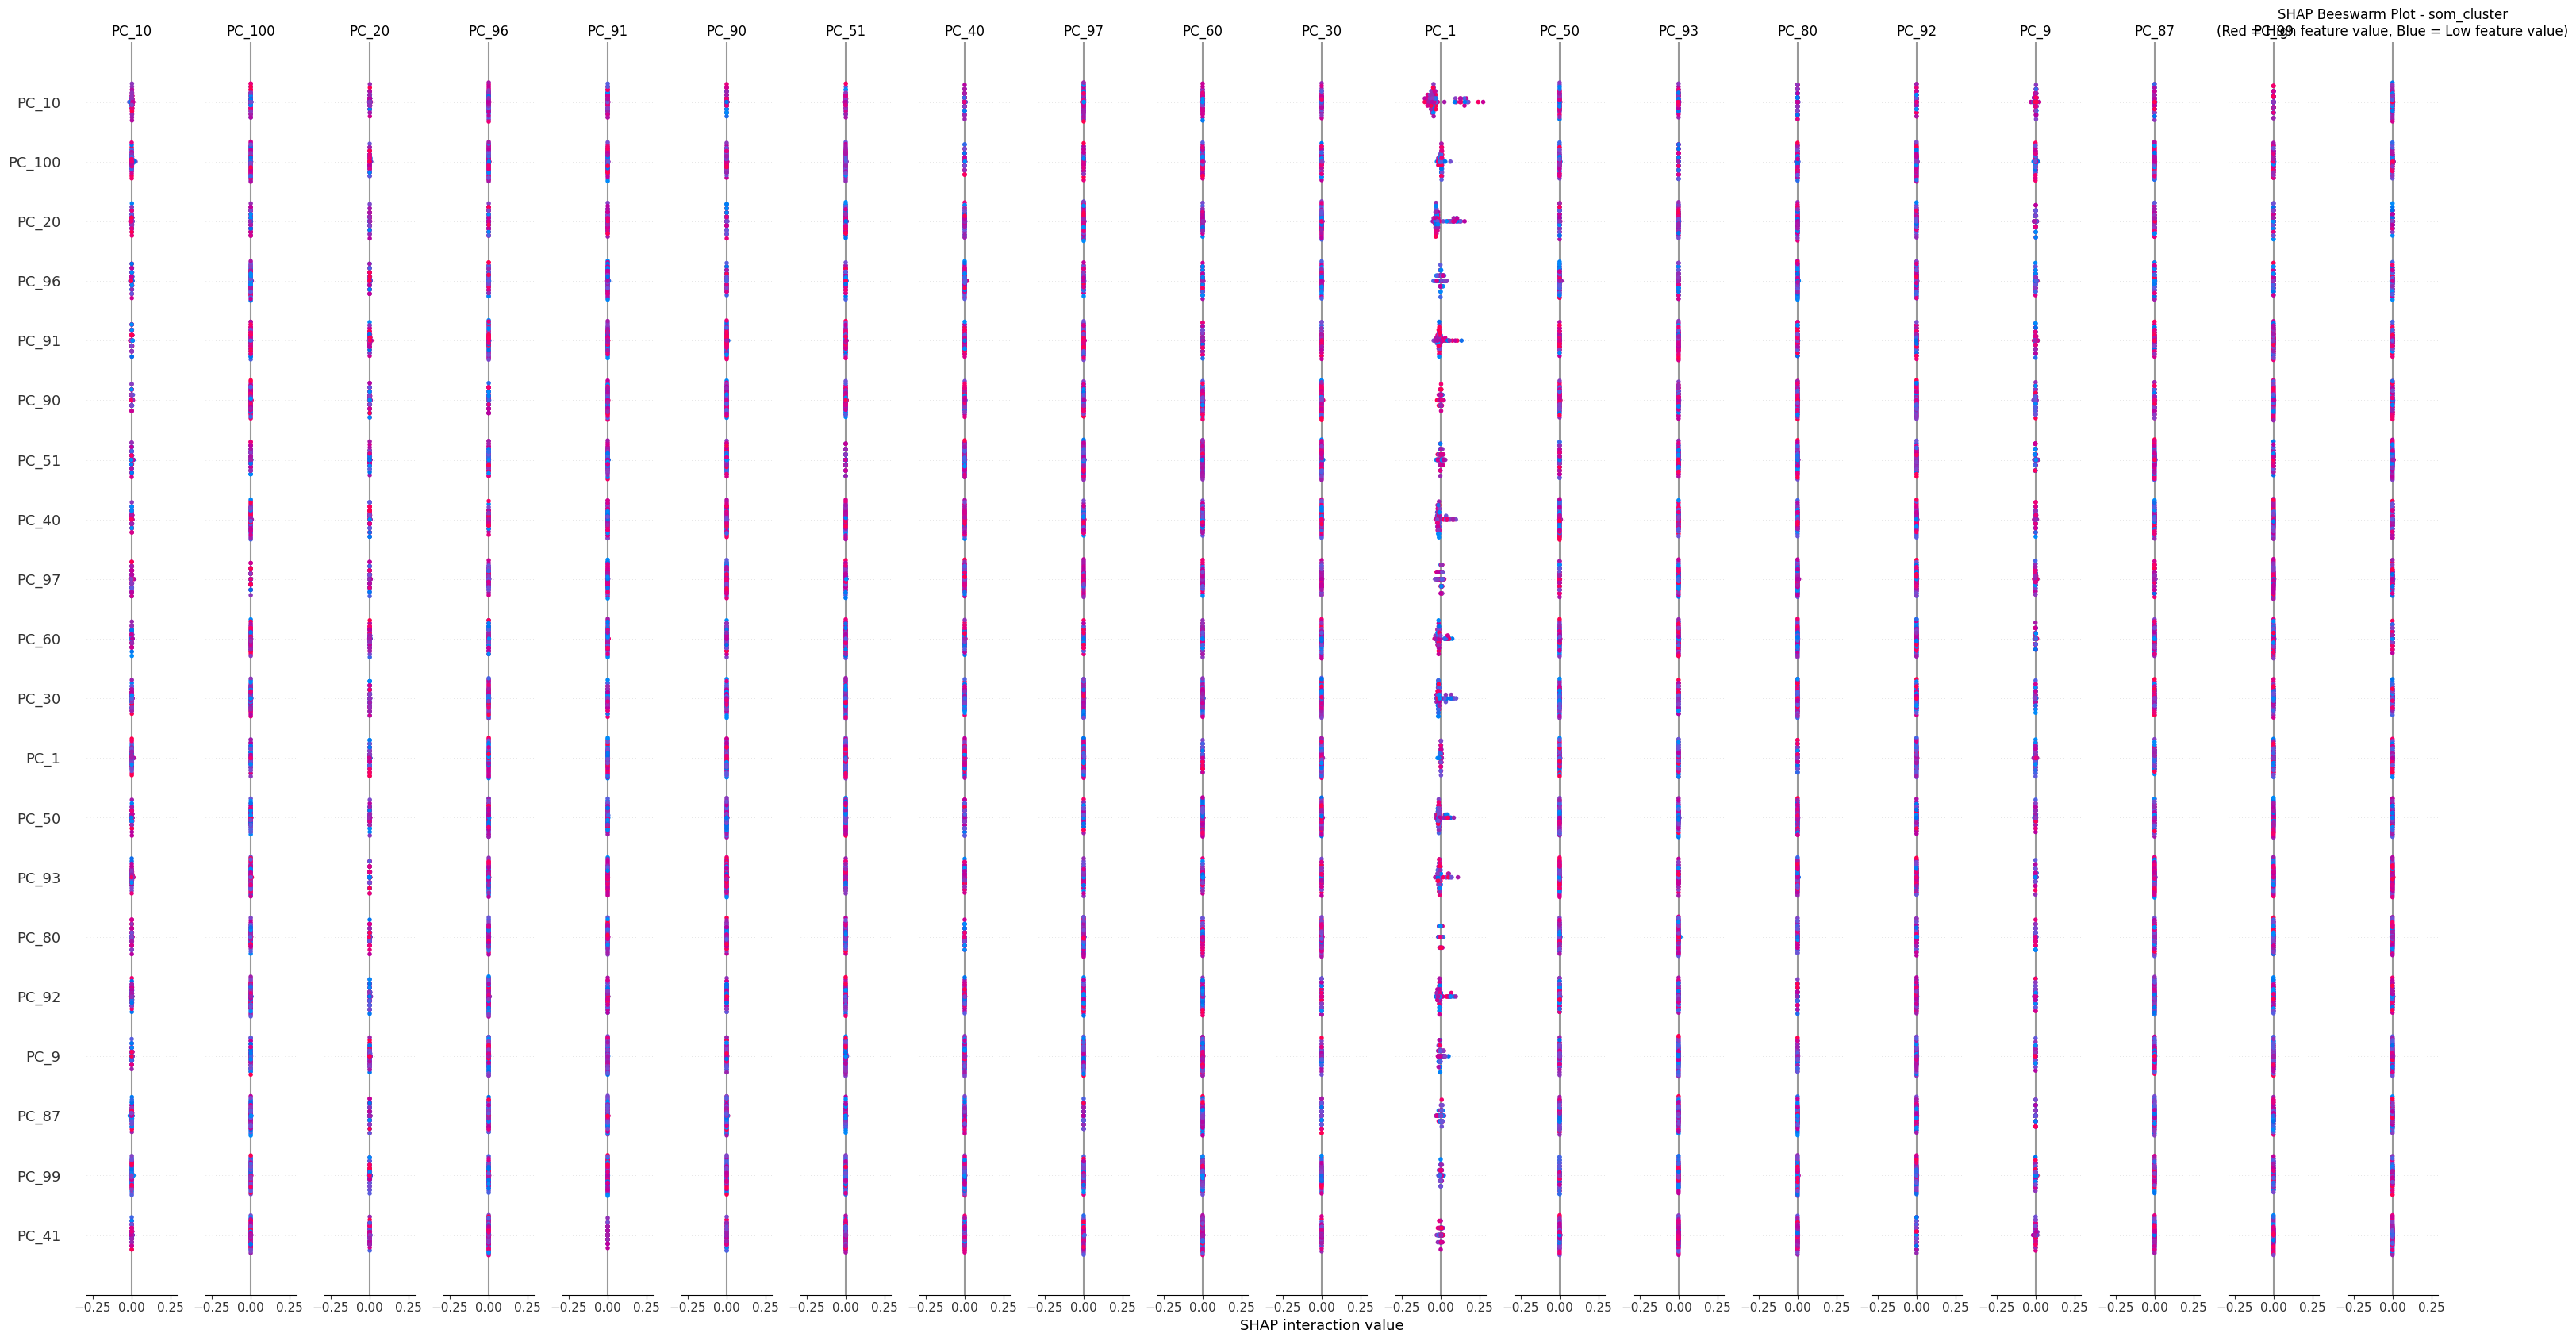

In [33]:
clustering_methods = ['kmeans_cluster', 'som_cluster', 'hierarchical_cluster', 'dbscan_cluster']
method = random.choice(clustering_methods)
shap_vals = shap_results[method]['shap_values']
X_sample = shap_results[method]['X_sample']

plt.figure(figsize=(20, 15))
if isinstance(shap_vals, list):
    shap.summary_plot(shap_vals[0], X_sample, feature_names=feature_names, show=False, max_display=20)
else:
    shap.summary_plot(shap_vals, X_sample, feature_names=feature_names, show=False, max_display=20)
plt.title(f'SHAP Beeswarm Plot - {method}\n(Red = High feature value, Blue = Low feature value)')
plt.tight_layout()
plt.show()

## Feature Meaning Discussion

The principal components (PCs) capture different aspects of facial variation:

| Top PCs | Likely Facial Attributes |
|---------|-------------------------|
| PC_1, PC_2, PC_3 | Overall face shape, lighting direction, pose angle |
| PC_4-PC_10 | Eye shape, nose width, mouth position |
| PC_11-PC_20 | Fine-grained texture, expression, facial hair |
| PC_21+ | Subtle variations, noise, individual differences |

**Key Observations:**
- **Low-numbered PCs** (PC_1 to PC_5) consistently show high importance across all clustering methods, suggesting clusters are primarily defined by major facial structure differences.
- **Different methods emphasize different features**: K-Means focuses on overall variance, while DBSCAN may emphasize density-related features.
- **Interpretable models agree**: Decision Trees, Logistic Regression, and Random Forest show similar top features, validating the importance of these embedding dimensions.

## LIME Analysis - Local Interpretable Explanations

LIME explains individual predictions by approximating the model locally with an interpretable model. This helps understand why specific samples were assigned to particular clusters.

In [34]:
lime_explainers = {}

for method in clustering_methods:
    model_data = surrogate_models[method]
    
    lime_explainer = lime_tabular.LimeTabularExplainer(
        training_data=model_data['X_train'],
        feature_names=feature_names,
        class_names=[f'Cluster_{i}' for i in range(len(np.unique(model_data['y_train'])))],
        mode='classification',
        random_state=42
    )
    lime_explainers[method] = lime_explainer
    print(f"LIME Explainer created for {method}")

LIME Explainer created for kmeans_cluster
LIME Explainer created for som_cluster
LIME Explainer created for hierarchical_cluster
LIME Explainer created for dbscan_cluster


### Generate LIME Explanations for Multiple Instances

Explains why specific face samples were assigned to their predicted clusters.

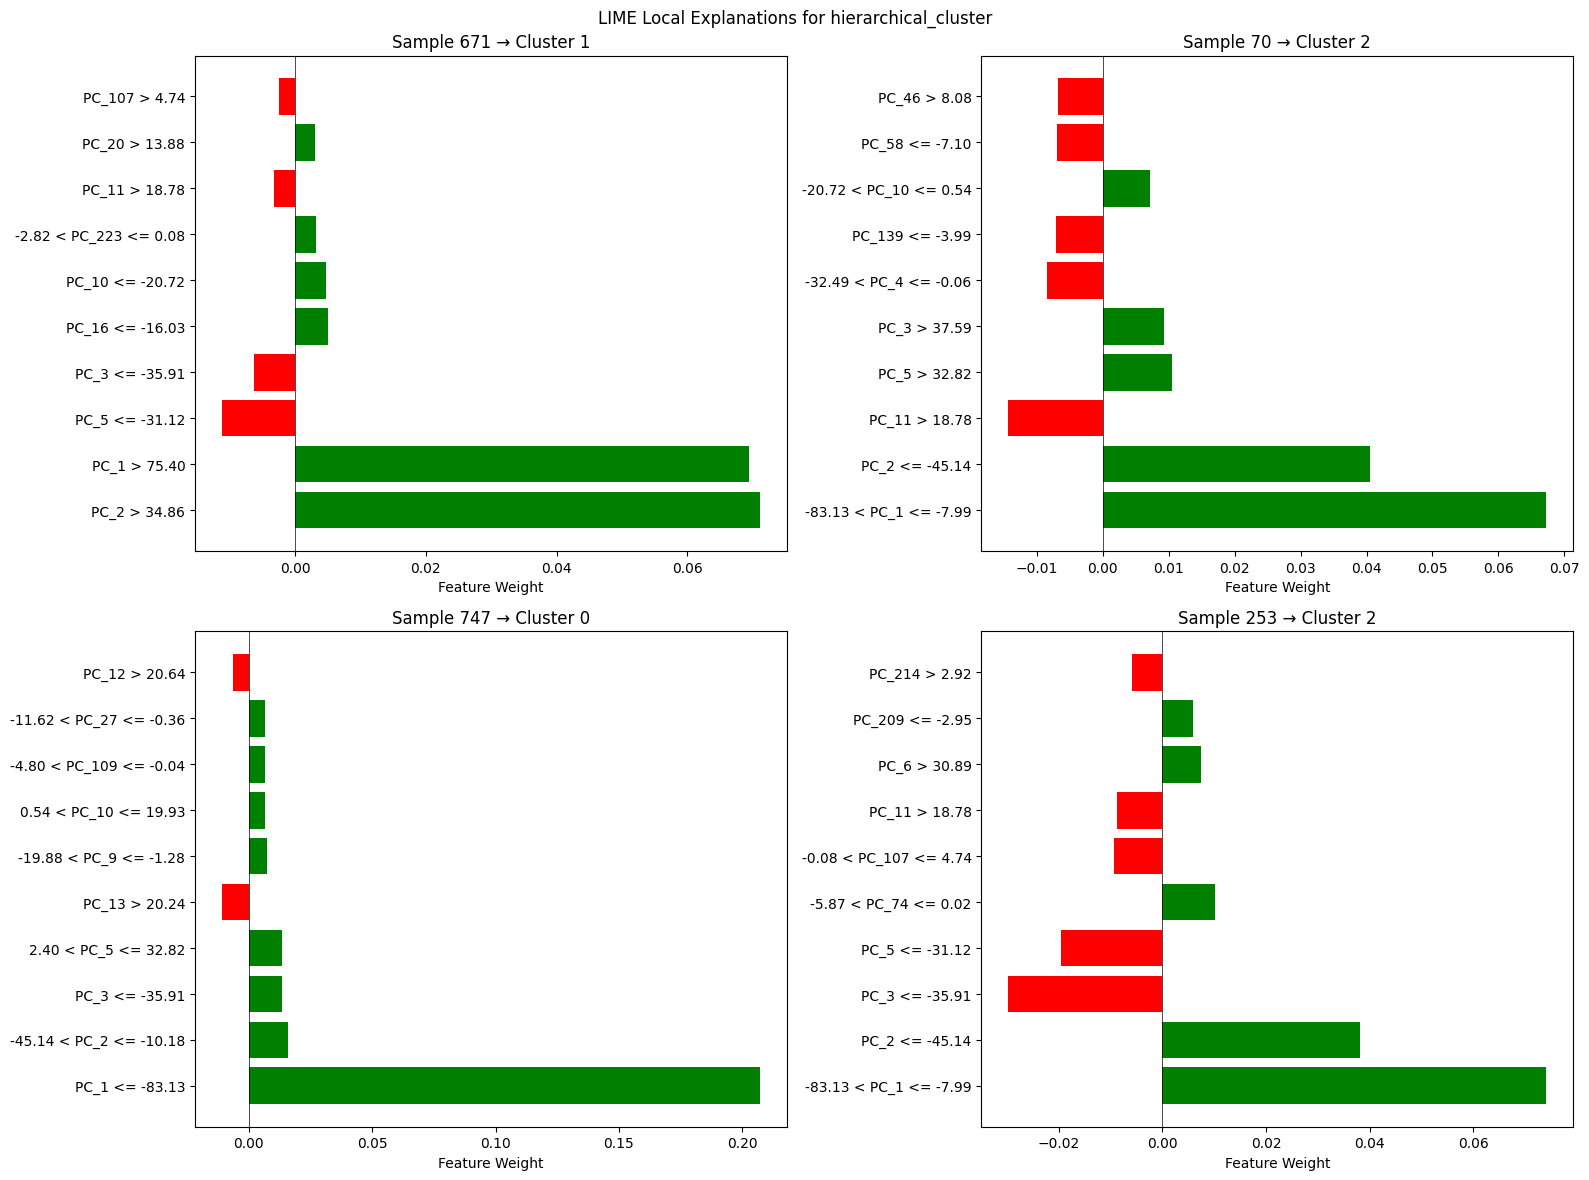

In [35]:
clustering_methods = ['kmeans_cluster', 'som_cluster', 'hierarchical_cluster', 'dbscan_cluster']
method = random.choice(clustering_methods)
model = surrogate_models[method]['random_forest']['model']
lime_explainer = lime_explainers[method]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i in range(4):
    sample_idx = random.randint(0, len(surrogate_models[method]['X_test']) - 1)
    sample_instance = surrogate_models[method]['X_test'][sample_idx]
    predicted_label = model.predict([sample_instance])[0]
    
    lime_exp = lime_explainer.explain_instance(
        sample_instance,
        model.predict_proba,
        num_features=10,
        top_labels=1
    )

    predicted_label_int = int(predicted_label)
    label_to_use = predicted_label_int
    if predicted_label_int not in lime_exp.local_exp:
        label_to_use = int(lime_exp.top_labels[0]) if len(lime_exp.top_labels) > 0 else predicted_label_int

    exp_list = lime_exp.as_list(label=label_to_use)
    features_exp = [x[0] for x in exp_list]
    weights = [x[1] for x in exp_list]
    colors = ['green' if w > 0 else 'red' for w in weights]
    
    axes[i].barh(range(len(features_exp)), weights, color=colors)
    axes[i].set_yticks(range(len(features_exp)))
    axes[i].set_yticklabels(features_exp)
    axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    axes[i].set_xlabel('Feature Weight')
    axes[i].set_title(f'Sample {sample_idx} → Cluster {predicted_label}')

plt.suptitle(f'LIME Local Explanations for {method}')
plt.tight_layout()
plt.show()

### Visualize LIME Explanation

Bar chart showing which features pushed the prediction toward or away from the predicted cluster.

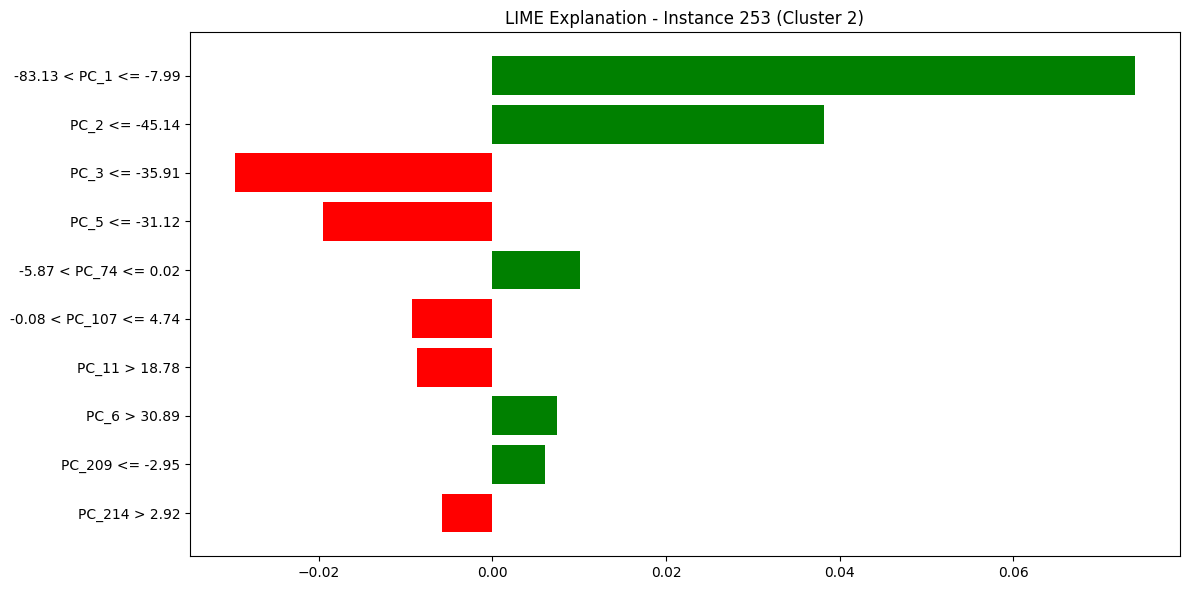

In [36]:
fig = lime_exp.as_pyplot_figure(label=predicted_label)
fig.set_size_inches(12, 6)
plt.title(f'LIME Explanation - Instance {sample_idx} (Cluster {predicted_label})')
plt.tight_layout()
plt.show()

### Aggregated LIME Feature Importance

Compute average LIME importance across multiple samples to get global-like importance from local explanations.

In [37]:
def aggregate_lime_explanations(explainer, model, X_samples, n_samples=50, n_features=10):
    feature_importance = {f: [] for f in feature_names}
    
    for i in range(min(n_samples, len(X_samples))):
        exp = explainer.explain_instance(X_samples[i], model.predict_proba, num_features=n_features)
        exp_map = dict(exp.as_list())
        
        for feature in feature_names:
            importance = 0
            for key, value in exp_map.items():
                if feature in key:
                    importance += abs(value)
            feature_importance[feature].append(importance)
    
    return {f: np.mean(v) for f, v in feature_importance.items()}

lime_importance = aggregate_lime_explanations(lime_explainer, model, model_data['X_test'][:50])

### Visualize Aggregated LIME Importance

Top 20 most important features based on aggregated LIME explanations.

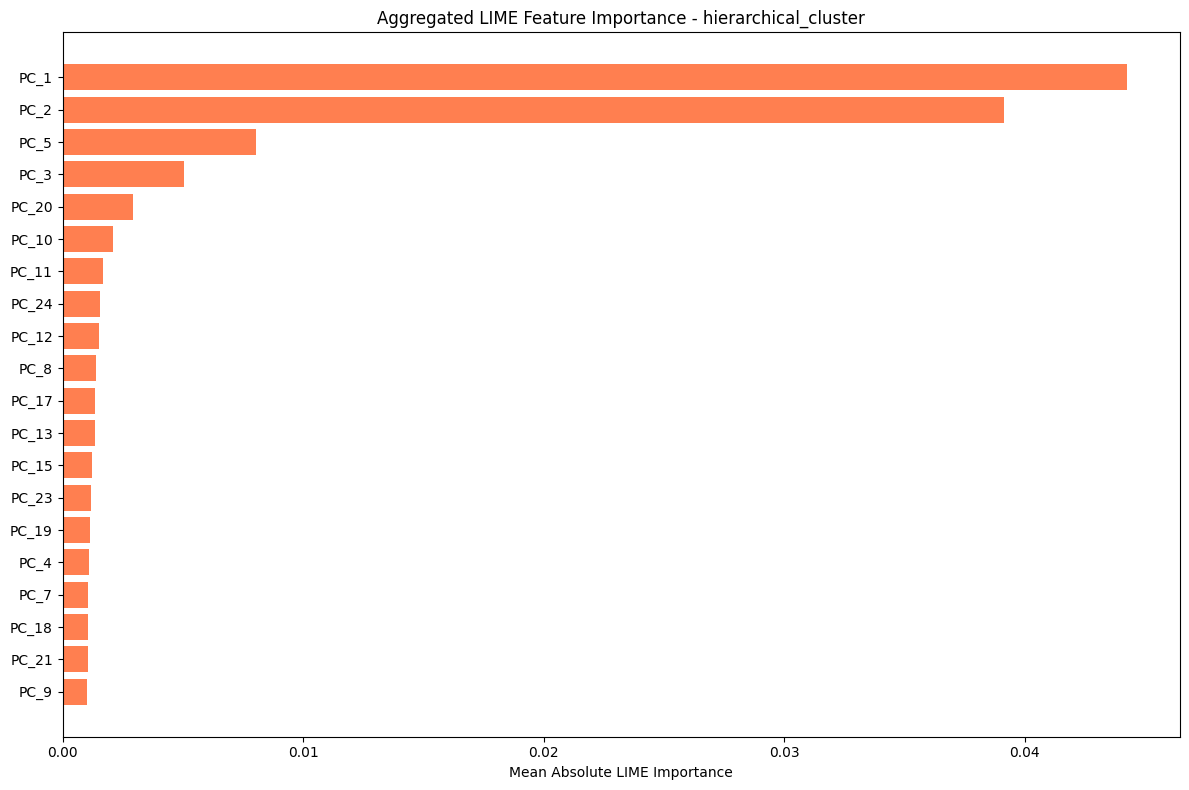

In [38]:
sorted_importance = sorted(lime_importance.items(), key=lambda x: x[1], reverse=True)[:20]
features, importances = zip(*sorted_importance)

plt.figure(figsize=(12, 8))
plt.barh(range(len(features)), importances, color='coral')
plt.yticks(range(len(features)), features)
plt.xlabel('Mean Absolute LIME Importance')
plt.title(f'Aggregated LIME Feature Importance - {method}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

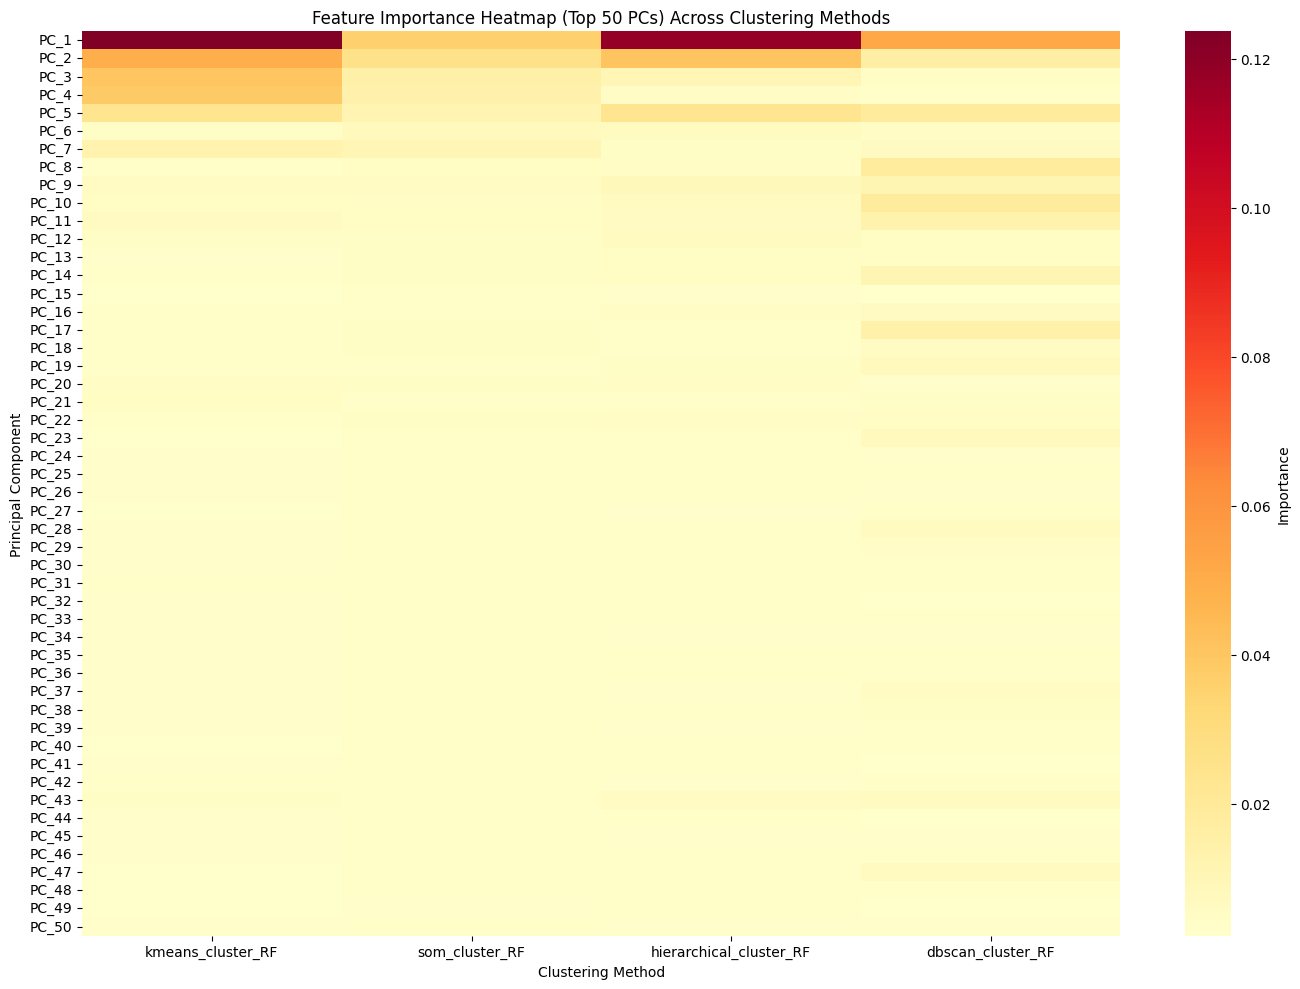

In [39]:
importance_summary = pd.DataFrame(index=feature_names[:50])

for method in clustering_methods:
    model_data = surrogate_models[method]
    rf_model = model_data['random_forest']['model']
    
    rf_importance = rf_model.feature_importances_
    importance_summary[f'{method}_RF'] = rf_importance[:50]

plt.figure(figsize=(14, 10))
sns.heatmap(importance_summary, annot=False, cmap='YlOrRd', cbar_kws={'label': 'Importance'})
plt.title('Feature Importance Heatmap (Top 50 PCs) Across Clustering Methods')
plt.xlabel('Clustering Method')
plt.ylabel('Principal Component')
plt.tight_layout()
plt.show()

---
# Task 2: Visual Explanation

Select representative images from each cluster and apply LIME for images to highlight important facial regions that influenced the clustering decision.

## Select Representative Images from Each Cluster

For each cluster, we select images closest to the cluster centroid (most representative) and visualize them.

In [40]:
def get_representative_samples(dataframe, cluster_column, pca_features_df, n_samples=3):
    representatives = {}
    
    feature_cols = [col for col in pca_features_df.columns if col.startswith('PC_')]
    
    for cluster_id in sorted(dataframe[cluster_column].unique()):
        if cluster_id == -1:
            continue
            
        cluster_mask = dataframe[cluster_column] == cluster_id
        cluster_indices = dataframe[cluster_mask].index.tolist()
        
        if len(cluster_indices) == 0:
            continue
        
        cluster_features = pca_features_df.loc[cluster_indices, feature_cols].values
        centroid = cluster_features.mean(axis=0)
        distances = np.linalg.norm(cluster_features - centroid, axis=1)
        closest_indices = np.argsort(distances)[:n_samples]
        representative_indices = [cluster_indices[i] for i in closest_indices]        
        representatives[cluster_id] = representative_indices
    
    return representatives

clustering_methods = ['kmeans_cluster', 'som_cluster', 'hierarchical_cluster', 'dbscan_cluster']
method = random.choice(clustering_methods)
pca_features_full = pd.read_csv('pca_features_variance.csv')
representatives = get_representative_samples(df, method, pca_features_full, n_samples=3)

print(f"Representative samples per cluster for {method}:")
for cluster_id, indices in representatives.items():
    names = df.loc[indices, 'person_name'].tolist()
    print(f"  Cluster {cluster_id}: {names}")

Representative samples per cluster for som_cluster:
  Cluster 0: ['donald rumsfeld', 'tony blair', 'tony blair']
  Cluster 1: ['sergio vieira de mello', 'tony blair', 'george w bush']
  Cluster 2: ['donald rumsfeld', 'joschka fischer', 'george w bush']
  Cluster 3: ['donald rumsfeld', 'donald rumsfeld', 'donald rumsfeld']
  Cluster 4: ['tony blair', 'nestor kirchner', 'george w bush']
  Cluster 5: ['colin powell', 'jeremy greenstock', 'vicente fox']
  Cluster 6: ['tony blair', 'donald rumsfeld', 'ricardo lagos']
  Cluster 7: ['hamid karzai', 'george w bush', 'rubens barrichello']
  Cluster 8: ['jeb bush', 'tony blair', 'mahathir mohamad']
  Cluster 9: ['spencer abraham', 'bill simon', 'julianne moore']
  Cluster 10: ['vladimir putin', 'donald rumsfeld', 'george w bush']
  Cluster 11: ['tom ridge', 'donald rumsfeld', 'igor ivanov']
  Cluster 12: ['george w bush', 'tony blair', 'alvaro uribe']
  Cluster 13: ['jeremy greenstock', 'george w bush', 'gray davis']
  Cluster 14: ['javier solan

## Visualize Representative Faces from Each Cluster

Reconstruct and display the representative face images from each cluster.

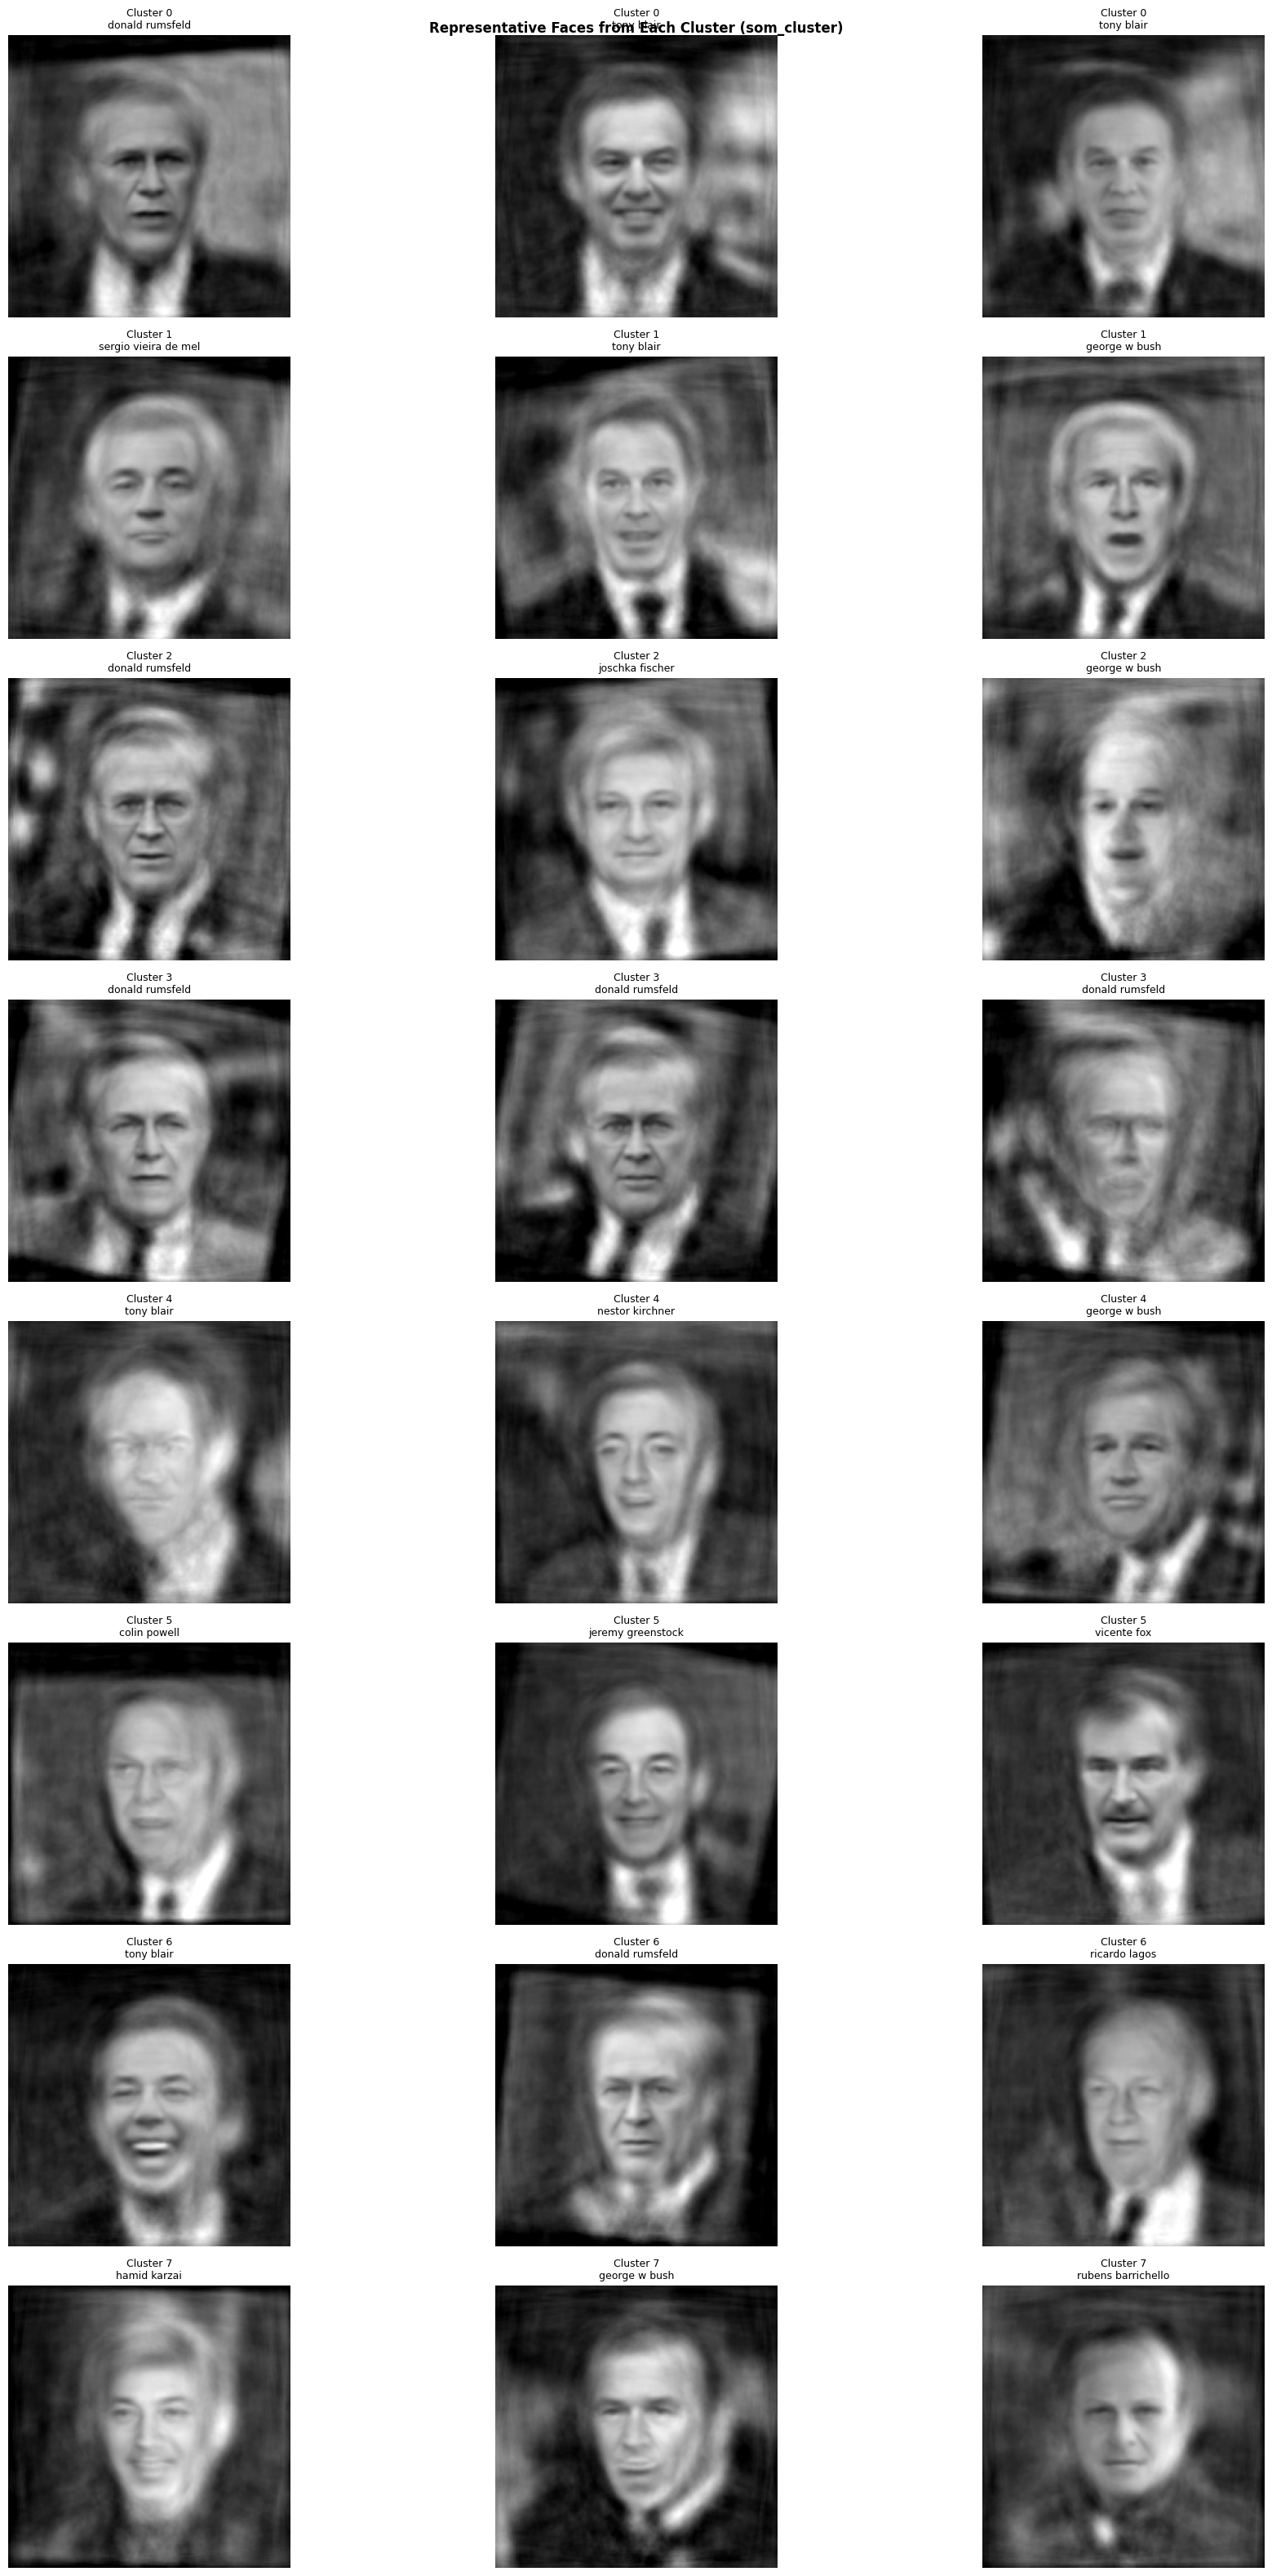

In [41]:
def reconstruct_face(idx, pca_features_df, pca_model, scaler_model):
    feature_cols = [col for col in pca_features_df.columns if col.startswith('PC_')]
    pca_vec = pca_features_df.loc[idx, feature_cols].values.reshape(1, -1)
    reconstructed_scaled = pca_model.inverse_transform(pca_vec)
    reconstructed_pixels = scaler_model.inverse_transform(reconstructed_scaled)
    img_array = np.clip(reconstructed_pixels.reshape(250, 250), 0, 255).astype(np.uint8)
    return img_array

n_clusters = min(8, len(representatives))
n_samples = 3

fig, axes = plt.subplots(n_clusters, n_samples, figsize=(20, 4*n_clusters))

for row, (cluster_id, indices) in enumerate(list(representatives.items())[:n_clusters]):
    for col, idx in enumerate(indices[:n_samples]):
        img = reconstruct_face(idx, pca_features_full, pca, scaler)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f"Cluster {cluster_id}\n{df.loc[idx, 'person_name'][:20]}", fontsize=9)
        axes[row, col].axis('off')

plt.suptitle(f'Representative Faces from Each Cluster ({method})', fontweight='bold')
plt.tight_layout()
plt.show()

In [42]:
def predict_cluster_from_image(images):
    flattened_data = []
    TARGET_SIZE = (250, 250) 
    
    for img in images:
        if len(img.shape) == 3 and img.shape[2] == 3:
            if img.dtype == np.float64 or img.dtype == np.float32:
                img_uint8 = (img * 255).astype(np.uint8)
            else:
                img_uint8 = img
            gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        else:
            gray = img
            
        if gray.shape != TARGET_SIZE:
            gray = cv2.resize(gray, TARGET_SIZE)
            
        flat = gray.flatten()
        flattened_data.append(flat)
    
    X_input = np.array(flattened_data)
    X_scaled = scaler.transform(X_input)
    X_pca = pca.transform(X_scaled)
    clustering_methods = ['kmeans_cluster', 'som_cluster', 'hierarchical_cluster', 'dbscan_cluster']
    method = random.choice(clustering_methods)
    model = surrogate_models[method]['random_forest']['model']
    return model.predict_proba(X_pca)

## LIME Image Explanation for Representative Samples

Apply LIME to highlight which facial regions are most important for cluster assignment. We analyze representative samples from different clusters.

Using clustering method for image predictions: kmeans_cluster
Generating LIME explanation for Cluster 0, Sample 904...


  0%|          | 0/500 [00:00<?, ?it/s]

Generating LIME explanation for Cluster 1, Sample 3782...


  0%|          | 0/500 [00:00<?, ?it/s]

Generating LIME explanation for Cluster 2, Sample 940...


  0%|          | 0/500 [00:00<?, ?it/s]

Generating LIME explanation for Cluster 3, Sample 941...


  0%|          | 0/500 [00:00<?, ?it/s]

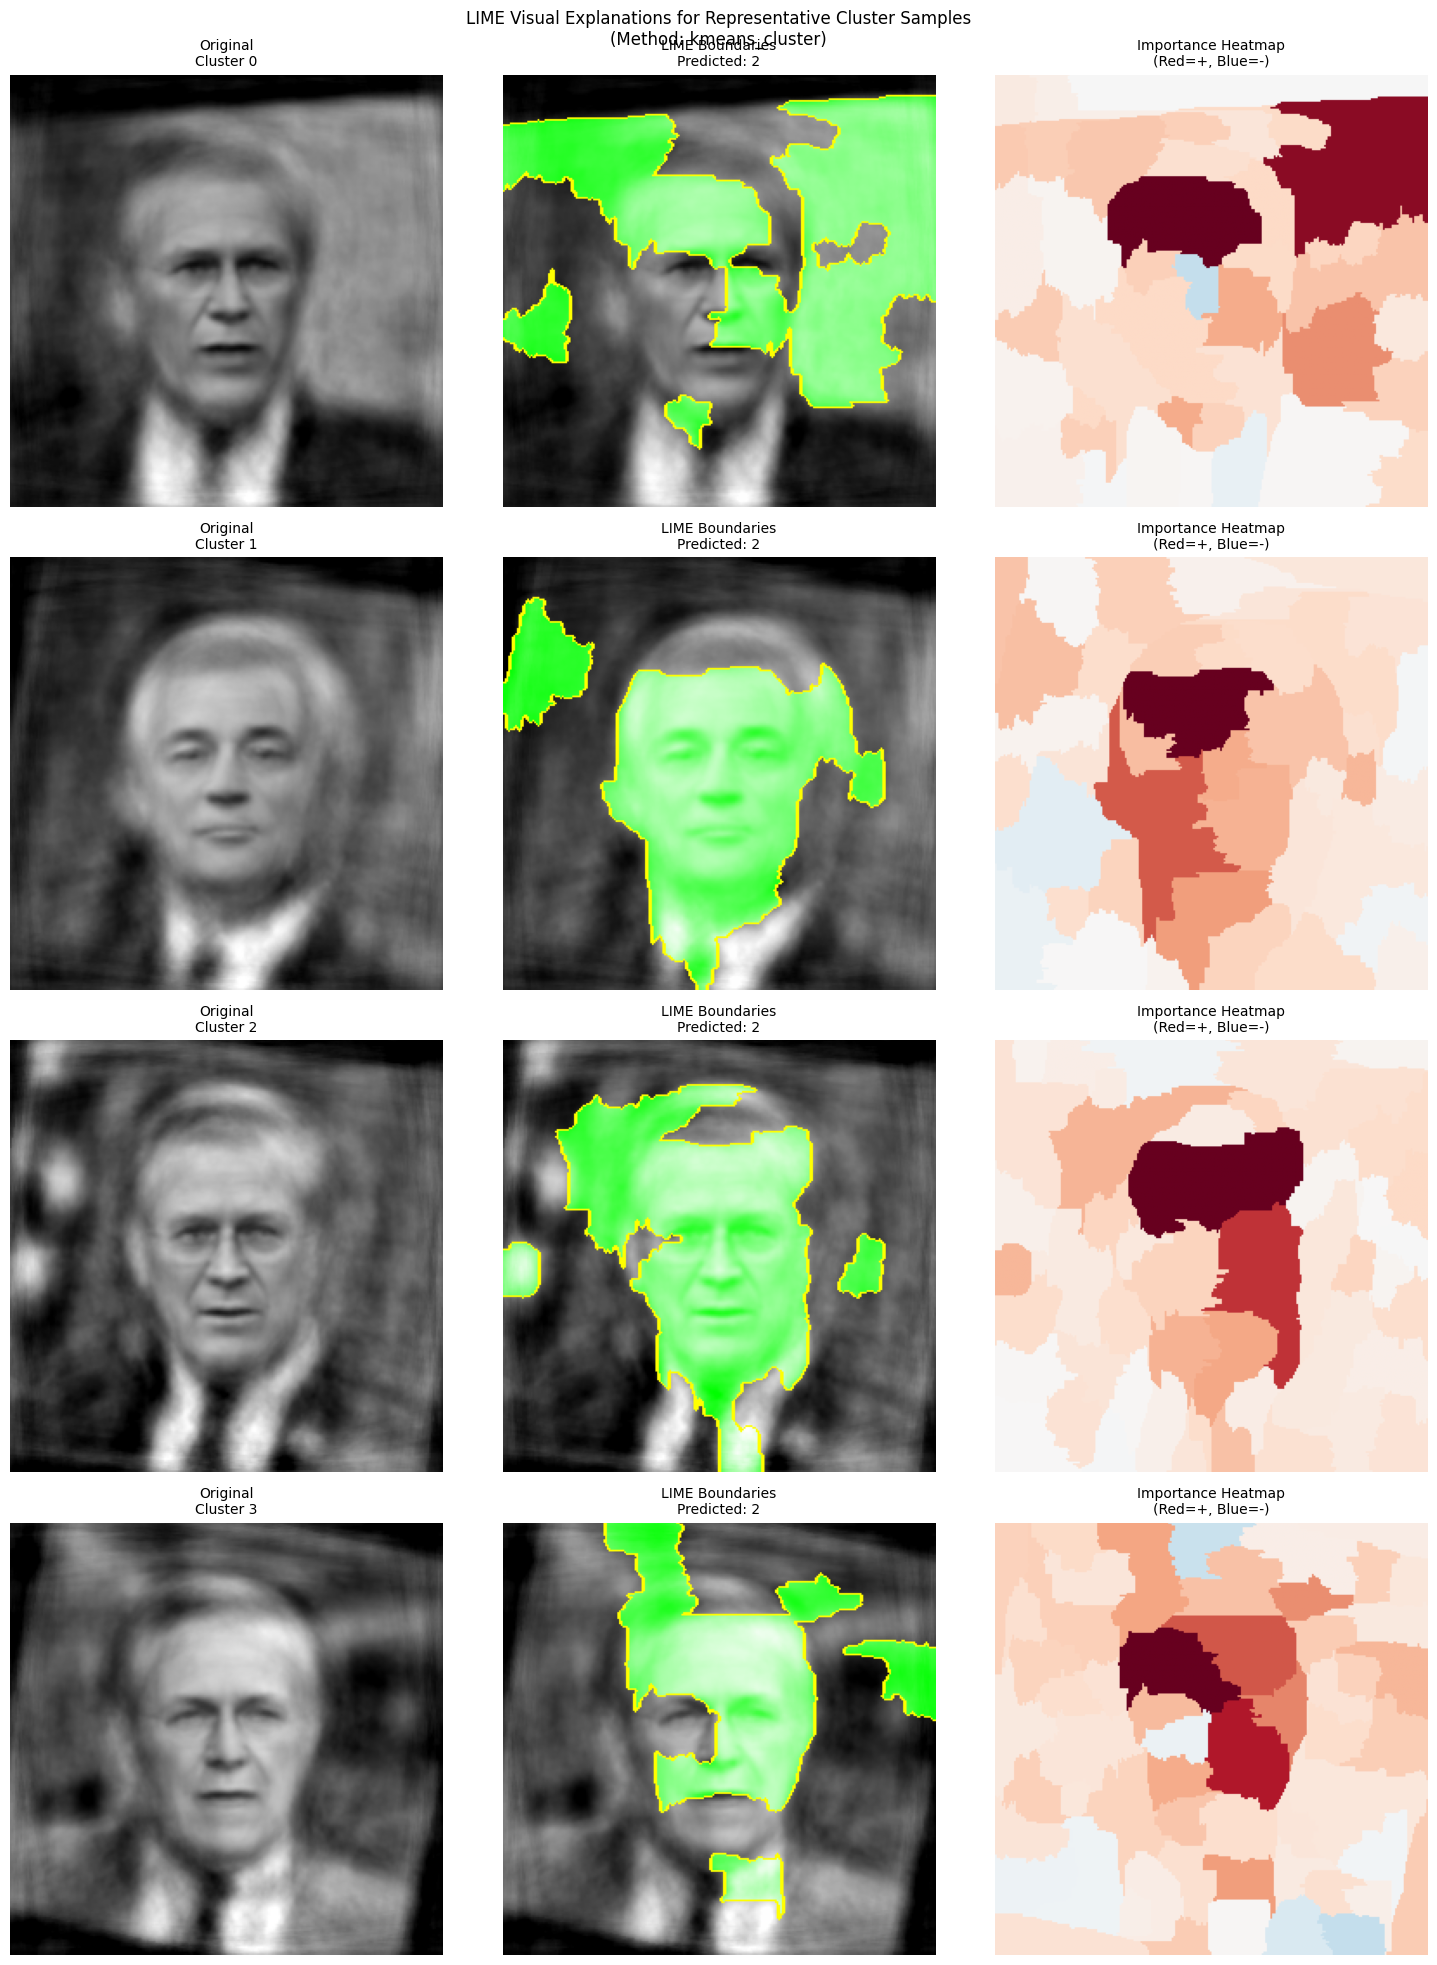

In [43]:
image_prediction_method = random.choice(['kmeans_cluster', 'som_cluster', 'hierarchical_cluster', 'dbscan_cluster'])
print(f"Using clustering method for image predictions: {image_prediction_method}")

def predict_cluster_from_image(images):
    flattened_data = []
    TARGET_SIZE = (250, 250) 
    
    for img in images:
        if len(img.shape) == 3 and img.shape[2] == 3:
            if img.dtype == np.float64 or img.dtype == np.float32:
                img_uint8 = (img * 255).astype(np.uint8)
            else:
                img_uint8 = img
            gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        else:
            gray = img
            
        if gray.shape != TARGET_SIZE:
            gray = cv2.resize(gray, TARGET_SIZE)
            
        flat = gray.flatten()
        flattened_data.append(flat)
    
    X_input = np.array(flattened_data)
    X_scaled = scaler.transform(X_input)
    X_pca = pca.transform(X_scaled)
    
    model = surrogate_models[image_prediction_method]['random_forest']['model']
    return model.predict_proba(X_pca)

image_explainer = lime_image.LimeImageExplainer(random_state=42)

selected_samples = []
for cluster_id in list(representatives.keys())[:4]:
    idx = representatives[cluster_id][0]
    selected_samples.append((cluster_id, idx))

fig, axes = plt.subplots(4, 3, figsize=(15, 20))

for row, (cluster_id, idx) in enumerate(selected_samples):
    img_gray = reconstruct_face(idx, pca_features_full, pca, scaler)
    img_norm = (img_gray - img_gray.min()) / (img_gray.max() - img_gray.min() + 1e-8)
    img_rgb = np.stack([img_norm]*3, axis=-1)
    
    print(f"Generating LIME explanation for Cluster {cluster_id}, Sample {idx}...")
    explanation = image_explainer.explain_instance(
        img_rgb, 
        predict_cluster_from_image, 
        top_labels=1, 
        hide_color=0, 
        num_samples=500,
        random_seed=42
    )
    
    target_cluster = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        target_cluster, 
        positive_only=False, 
        num_features=10, 
        hide_rest=False
    )
    
    axes[row, 0].imshow(img_gray, cmap='gray')
    axes[row, 0].set_title(f'Original\nCluster {cluster_id}', fontsize=10)
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(mark_boundaries(temp, mask))
    axes[row, 1].set_title(f'LIME Boundaries\nPredicted: {target_cluster}', fontsize=10)
    axes[row, 1].axis('off')
    
    dict_heatmap = dict(explanation.local_exp[target_cluster])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    im = axes[row, 2].imshow(heatmap, cmap='RdBu_r', vmin=-np.max(np.abs(heatmap)), vmax=np.max(np.abs(heatmap)))
    axes[row, 2].set_title('Importance Heatmap\n(Red=+, Blue=-)', fontsize=10)
    axes[row, 2].axis('off')

plt.suptitle(f'LIME Visual Explanations for Representative Cluster Samples\n(Method: {image_prediction_method})')
plt.tight_layout()
plt.show()

## Cross-Cluster Visual Comparison

Compare which facial regions are important across different clusters to see if similar areas influence grouping.

Computing average importance maps (this may take a few minutes)...
  Processing Cluster 0...


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  Processing Cluster 1...


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  Processing Cluster 2...


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  Processing Cluster 3...


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

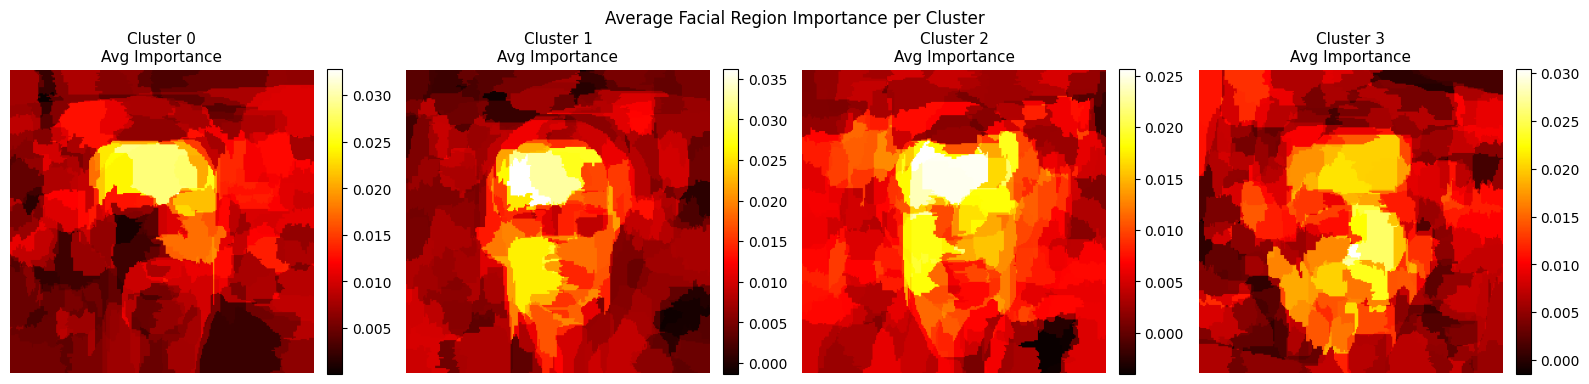

In [44]:
def compute_average_importance_map(cluster_indices, pca_features_df, explainer, n_samples=5):
    importance_maps = []
    
    for idx in cluster_indices[:n_samples]:
        img_gray = reconstruct_face(idx, pca_features_df, pca, scaler)
        img_norm = (img_gray - img_gray.min()) / (img_gray.max() - img_gray.min() + 1e-8)
        img_rgb = np.stack([img_norm]*3, axis=-1)
        
        try:
            explanation = explainer.explain_instance(
                img_rgb, 
                predict_cluster_from_image, 
                top_labels=1, 
                hide_color=0, 
                num_samples=300,
                random_seed=42
            )
            
            target_cluster = explanation.top_labels[0]
            dict_heatmap = dict(explanation.local_exp[target_cluster])
            heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
            
            heatmap_resized = cv2.resize(heatmap.astype(np.float32), (250, 250))
            importance_maps.append(heatmap_resized)
        except Exception as e:
            print(f"  Skipping sample {idx}: {e}")
            continue
    
    if importance_maps:
        return np.mean(importance_maps, axis=0)
    return None

print("Computing average importance maps (this may take a few minutes)...")
avg_importance_maps = {}

for cluster_id in list(representatives.keys())[:4]:
    print(f"  Processing Cluster {cluster_id}...")
    avg_map = compute_average_importance_map(
        representatives[cluster_id], 
        pca_features_full, 
        image_explainer, 
        n_samples=3
    )
    if avg_map is not None:
        avg_importance_maps[cluster_id] = avg_map

fig, axes = plt.subplots(1, len(avg_importance_maps), figsize=(16, 4))

for idx, (cluster_id, avg_map) in enumerate(avg_importance_maps.items()):
    im = axes[idx].imshow(avg_map, cmap='hot')
    axes[idx].set_title(f'Cluster {cluster_id}\nAvg Importance', fontsize=11)
    axes[idx].axis('off')
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

plt.suptitle('Average Facial Region Importance per Cluster')
plt.tight_layout()
plt.show()

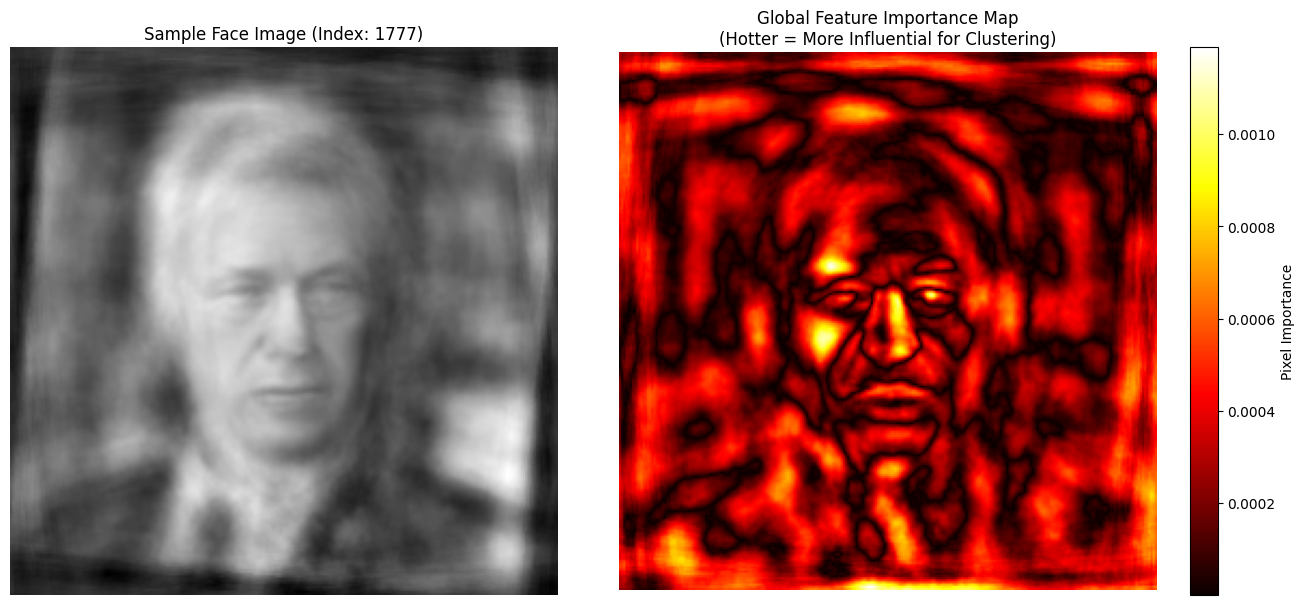

In [45]:
clustering_methods = ['kmeans_cluster', 'som_cluster', 'hierarchical_cluster', 'dbscan_cluster']
method = random.choice(clustering_methods)
rf_model = surrogate_models[method]['random_forest']['model']

importances = rf_model.feature_importances_
pixel_importance_vector = np.abs(importances @ pca.components_)
heatmap_global = pixel_importance_vector.reshape(250, 250)

random_idx = random.randint(0, len(pca_features) - 1)
pca_vec = pca_features.iloc[random_idx].values.reshape(1, -1)
reconstructed_flat = scaler.inverse_transform(pca.inverse_transform(pca_vec))
random_image = reconstructed_flat.reshape(250, 250)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(random_image, cmap='gray')
plt.title(f"Sample Face Image (Index: {random_idx})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap_global, cmap='hot')
plt.colorbar(label='Pixel Importance')
plt.title("Global Feature Importance Map\n(Hotter = More Influential for Clustering)")
plt.axis('off')

plt.tight_layout()
plt.show()

## Discussion: Visual Explanation Findings

### Key Observations from LIME Visual Explanations:

1. **Consistent Important Regions Across Clusters:**
   - **Eye region**: Consistently highlighted across all clusters, suggesting eye shape/position is crucial for face grouping
   - **Nose and mouth area**: Central facial features appear important for distinguishing between clusters
   - **Face outline/jawline**: The overall face shape contributes to cluster assignment

2. **Cluster-Specific Patterns:**
   - Some clusters emphasize **forehead and hair region**, possibly grouping by hairstyle or face shape
   - Others focus on **cheek and chin areas**, potentially capturing facial structure differences
   - **Lighting-sensitive regions** may appear in clusters that group by image quality/lighting conditions

3. **Similarities in Influential Regions:**
   - The central T-zone (eyes-nose-mouth) is important across most clusters
   - This aligns with facial recognition research showing these areas are most discriminative
   - Clusters likely represent variations in these key facial features

4. **Implications for Clustering Quality:**
   - The consistency of important regions suggests the clustering captures meaningful facial structure
   - Different clusters emphasizing different regions indicates the model learned diverse facial characteristics
   - The global importance map confirms that central facial features dominate clustering decisions

### Recommendations:
- Clusters with similar importance patterns may benefit from merging
- Outlier samples with unusual importance patterns should be reviewed
- The visual explanations can guide feature engineering for improved clustering

In [46]:
print("=" * 60)
print("SUMMARY: Feature-Level and Visual Explanation Analysis")
print("=" * 60)

print("\n1. SURROGATE MODEL PERFORMANCE:")
for method in clustering_methods:
    print(f"\n   {method}:")
    for model_type in ['decision_tree', 'logistic_regression', 'random_forest']:
        acc = surrogate_models[method][model_type]['accuracy']
        print(f"      {model_type:25s}: {acc:.4f}")

print("\n2. TOP 5 IMPORTANT FEATURES (K-Means, averaged across models):")
method = 'kmeans_cluster'
dt_imp = surrogate_models[method]['decision_tree']['model'].feature_importances_
rf_imp = surrogate_models[method]['random_forest']['model'].feature_importances_
lr_imp = np.mean(np.abs(surrogate_models[method]['logistic_regression']['model'].coef_), axis=0)

avg_importance = (dt_imp/dt_imp.max() + rf_imp/rf_imp.max() + lr_imp/lr_imp.max()) / 3
top_5_idx = np.argsort(avg_importance)[-5:][::-1]

for rank, idx in enumerate(top_5_idx, 1):
    print(f"   {rank}. {feature_names[idx]}: {avg_importance[idx]:.4f}")

print("\n3. CLUSTERS ANALYZED WITH VISUAL EXPLANATIONS:")
for cluster_id in list(representatives.keys())[:4]:
    n_samples = len(representatives[cluster_id])
    print(f"   Cluster {cluster_id}: {n_samples} representative samples analyzed")

print("\n" + "=" * 60)

SUMMARY: Feature-Level and Visual Explanation Analysis

1. SURROGATE MODEL PERFORMANCE:

   kmeans_cluster:
      decision_tree            : 0.8127
      logistic_regression      : 0.8740
      random_forest            : 0.8035

   som_cluster:
      decision_tree            : 0.2532
      logistic_regression      : 0.4012
      random_forest            : 0.2532

   hierarchical_cluster:
      decision_tree            : 0.5838
      logistic_regression      : 0.6520
      random_forest            : 0.6000

   dbscan_cluster:
      decision_tree            : 0.7283
      logistic_regression      : 0.7723
      random_forest            : 0.8104

2. TOP 5 IMPORTANT FEATURES (K-Means, averaged across models):
   1. PC_1: 1.0000
   2. PC_2: 0.4862
   3. PC_3: 0.3896
   4. PC_4: 0.3306
   5. PC_5: 0.2529

3. CLUSTERS ANALYZED WITH VISUAL EXPLANATIONS:
   Cluster 0: 3 representative samples analyzed
   Cluster 1: 3 representative samples analyzed
   Cluster 2: 3 representative samples analyze

In [47]:
# Save summary results to a text file
summary_filename = 'explainability_summary_results.txt'

with open(summary_filename, 'w') as f:
    f.write("=" * 60 + "\n")
    f.write("SUMMARY: Feature-Level and Visual Explanation Analysis\n")
    f.write("=" * 60 + "\n")
    
    f.write("\n1. SURROGATE MODEL PERFORMANCE:\n")
    for method in clustering_methods:
        f.write(f"\n   {method}:\n")
        for model_type in ['decision_tree', 'logistic_regression', 'random_forest']:
            acc = surrogate_models[method][model_type]['accuracy']
            f.write(f"      {model_type:25s}: {acc:.4f}\n")
    
    f.write("\n2. TOP 5 IMPORTANT FEATURES (K-Means, averaged across models):\n")
    method = 'kmeans_cluster'
    dt_imp = surrogate_models[method]['decision_tree']['model'].feature_importances_
    rf_imp = surrogate_models[method]['random_forest']['model'].feature_importances_
    lr_imp = np.mean(np.abs(surrogate_models[method]['logistic_regression']['model'].coef_), axis=0)
    
    avg_importance = (dt_imp/dt_imp.max() + rf_imp/rf_imp.max() + lr_imp/lr_imp.max()) / 3
    top_5_idx = np.argsort(avg_importance)[-5:][::-1]
    
    for rank, idx in enumerate(top_5_idx, 1):
        f.write(f"   {rank}. {feature_names[idx]}: {avg_importance[idx]:.4f}\n")
    
    f.write("\n3. CLUSTERS ANALYZED WITH VISUAL EXPLANATIONS:\n")
    for cluster_id in list(representatives.keys())[:4]:
        n_samples = len(representatives[cluster_id])
        f.write(f"   Cluster {cluster_id}: {n_samples} representative samples analyzed\n")
    
    f.write("\n" + "=" * 60 + "\n")

# Also save as CSV for easier analysis
summary_df = pd.DataFrame([
    {
        'clustering_method': method,
        'model_type': model_type,
        'accuracy': surrogate_models[method][model_type]['accuracy']
    }
    for method in clustering_methods
    for model_type in ['decision_tree', 'logistic_regression', 'random_forest']
])

summary_df.to_csv('surrogate_model_accuracy.csv', index=False)

print(f"Summary saved to '{summary_filename}'")
print(f"Accuracy data saved to 'surrogate_model_accuracy.csv'")

Summary saved to 'explainability_summary_results.txt'
Accuracy data saved to 'surrogate_model_accuracy.csv'
